### Cab-Driver Agent

In [ ]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

2021-10-18 14:42:24.259691: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2021-10-18 14:42:24.259736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


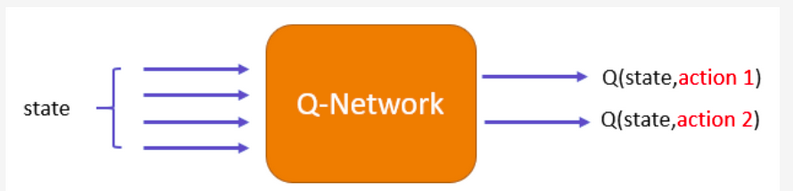

#### Defining Time Matrix

In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix.shape

(5, 5, 24, 7)

#### Tracking the state-action pairs for checking convergence


In [ ]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [ ]:
R_TRACK = 10
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.max_epsilon = 1
        self.epsilon = self.max_epsilon
        self.decay_rate = 0.001
        self.min_epsilon = 0.01
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        self.avg_reward = deque(maxlen=R_TRACK)
        # create main model and target model
        self.model = self.build_model()

        # Initialize the value of the states tracked for all samples
        self.states_tracked_1 = []
        self.states_tracked_2 = []
        # For Sample state-action pair 1: We are going to track state (2,4,6) and action (2,3) at index 11 in the action space.
        self.track_state_1 = np.array(env.state_encod_arch2((2,4,6))).reshape(1, self.state_size)
        # For Sample state-action pair 2: We are going to track state (1,2,3) and action (1,2) at index 6 in the action space.
        self.track_state_2 = np.array(env.state_encod_arch2((1,2,3))).reshape(1, self.state_size)


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        # model.add(Dense(32, activation='relu',
        #                 kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model



    def get_action(self, state):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment       
        
        # self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)

        z = np.random.random()
        if z <= self.epsilon:
            return random.choice(env.action_space)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) 
            state = np.array(env.state_encod_arch2(state)).reshape(1, self.state_size)

            # Use the model to predict the Q_values.
            action = self.model.predict(state)
            # return action
            # q_vals_possible = [action[0][i] for i in env.action_space]

            return env.action_space[np.argmax(action[0])]
    

    def append_sample(self, state, action, reward, next_state,done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, dones = [], [], []
            
            for i in range(self.batch_size):
                
                # Write your code from here
                state, action, reward, next_state, done = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state)
                dones.append(done)
            
            # 1. Predict the target from earlier model, Optimization preventing calls to multiple predicts
            # target = self.model.predict(update_input, max_queue_size=100, workers=2, use_multiprocessing=True)
            # target_qval = self.model.predict(update_output, max_queue_size=100, workers=2, use_multiprocessing=True)
            target = self.model.predict(np.vstack([update_input,update_output]))
            target_qval = target[int(len(target)/2):int(len(target))]
            target = target[0:int(len(target)/2)]
            # 2. Get the target for the Q-network
            
            
            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            for i in range(self.batch_size):
              if dones[i]:
                  target[i][env.action_encod(actions[i])] = rewards[i]
              else: # non-terminal state
                  # print(actions[i])
                  # print(target[i][actions[i]])
                  target[i][env.action_encod(actions[i])] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values        
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
                
        
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        # q_value_1 = self.model.predict(self.track_state_1)
        # q_value_2 = self.model.predict(self.track_state_2)
        q_value_1 = self.model.predict(np.vstack([self.track_state_1,self.track_state_2]))
        q_value_2 = q_value_1[int(len(q_value_1)/2):int(len(q_value_1))]
        q_value_1 = q_value_1[0:int(len(q_value_1)/2)]

        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_1.append(q_value_1[0][11])    ## action (2,3) at index 11 in the action space
        self.states_tracked_2.append(q_value_2[0][6])     ## action (1,2) at index 6 in the action space


    def save(self, name):
        self.model.save_weights(name)

In [ ]:
episode_time = 24*30   # 24 hrs for 30 days per episode
Episodes = 5000       # No. of Episodes

m = 5                  # No. Locations
t = 24                 # No. of hrs in a day
d = 7                  # No. of days in a week 
state_size = m+t+d  ## require as len for the encoded  nn input

# Invoke Env class
env = CabDriver()
# state = env.reset()

# Invoke agent class
agent = DQNAgent(action_size=len(env.action_space), state_size = state_size)  ### len(env.state_space)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state
rewards_init_state = []
score_tracked = []


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                693       
Total params: 1,877
Trainable params: 1,877
Non-trainable params: 0
_________________________________________________________________


2021-10-18 14:42:26.336287: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-18 14:42:26.336360: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-18 14:42:26.336423: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mohd-HP-ProBook-440-G3): /proc/driver/nvidia/version does not exist
2021-10-18 14:42:26.337019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-18 14:42:26.354320: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency:

### DQN block

In [ ]:
for episode in tqdm(range(Episodes)):

    terminal_state = False
    score = 0
    
    # Reset at the start of each episode
    state = env.reset()
    # State Initialization 
    initial_state = state


    total_time = 0  
    while not terminal_state:    
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(state)
        # 2. Evaluate your reward and next state
        next_state, reward, terminal_state = env.step(state, action, Time_matrix)
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        state = next_state
        total_time+=1
        
    # Store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
        
    agent.epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate*episode)
    agent.avg_reward.append(score)
    # Every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("\nepisode {0}, initial_state {1}, reward {2}, memory_length {3}, epsilon {4} total_epochs {5} episode_time {6}".format(episode+1, 
                                                                         initial_state,
                                                                         np.mean(agent.avg_reward),
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time, env.episode_time))

    # Total rewards per episode
    score_tracked.append(score)

    # Save the Q_value of the state-action pair we are tracking (every 5 episodes)
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    ## Saving the 'DQN_model' and 'model_weights' every 1000th episode.
    if((episode + 1) % 1000 == 0):
        save_obj(score_tracked, "score_tracked")
        print("Saving Model {}".format(episode))
        agent.save(name="DQN_model.h5")                     ## Saves DQN model in Keras H5 format
        save_obj(agent.states_tracked_1,"states_tracked_1")
        save_obj(agent.states_tracked_2,"states_tracked_2")
        # print("Saving Model {} Weights".format(episode))
        # agent.save_weights_numpy(name="model_weights.pkl")

  0%|                                                                                                      | 1/5000 [00:07<10:02:53,  7.24s/it]

Saving Model 0


  0%|▏                                                                                                    | 10/5000 [01:30<12:56:07,  9.33s/it]


episode 10, initial_state (2, 13, 5), reward -85.9, memory_length 1155, epsilon 0.9911299749851548 total_epochs 120 episode_time 731.0


  0%|▍                                                                                                    | 20/5000 [03:09<13:47:42,  9.97s/it]


episode 20, initial_state (2, 11, 5), reward 35.9, memory_length 2000, epsilon 0.9813675686203779 total_epochs 114 episode_time 723.0


  1%|▌                                                                                                    | 30/5000 [04:54<14:20:58, 10.39s/it]


episode 30, initial_state (4, 0, 3), reward 26.0, memory_length 2000, epsilon 0.9717022998219388 total_epochs 124 episode_time 721.0


  1%|▊                                                                                                    | 40/5000 [06:32<13:00:49,  9.45s/it]


episode 40, initial_state (1, 5, 3), reward 59.1, memory_length 2000, epsilon 0.962133202054903 total_epochs 112 episode_time 725.0


  1%|█                                                                                                    | 50/5000 [08:09<14:04:29, 10.24s/it]


episode 50, initial_state (4, 23, 6), reward 55.9, memory_length 2000, epsilon 0.9526593184015199 total_epochs 116 episode_time 724.0


  1%|█▏                                                                                                   | 60/5000 [09:43<12:40:51,  9.24s/it]


episode 60, initial_state (3, 2, 2), reward 40.1, memory_length 2000, epsilon 0.9432797014655288 total_epochs 119 episode_time 732.0


  1%|█▍                                                                                                   | 70/5000 [11:19<12:29:37,  9.12s/it]


episode 70, initial_state (4, 9, 4), reward -18.2, memory_length 2000, epsilon 0.9339934132774199 total_epochs 107 episode_time 724.0


  2%|█▌                                                                                                   | 80/5000 [12:54<13:07:21,  9.60s/it]


episode 80, initial_state (3, 21, 6), reward 4.0, memory_length 2000, epsilon 0.9247995252006359 total_epochs 125 episode_time 724.0


  2%|█▊                                                                                                   | 90/5000 [14:37<13:37:07,  9.99s/it]


episode 90, initial_state (1, 0, 0), reward -19.8, memory_length 2000, epsilon 0.9156971178387074 total_epochs 117 episode_time 722.0


  2%|██                                                                                                  | 100/5000 [16:12<13:30:36,  9.93s/it]


episode 100, initial_state (2, 17, 4), reward -5.3, memory_length 2000, epsilon 0.906685280943313 total_epochs 117 episode_time 722.0


  2%|██▏                                                                                                 | 110/5000 [18:01<14:59:35, 11.04s/it]


episode 110, initial_state (2, 16, 3), reward 131.8, memory_length 2000, epsilon 0.8977631133232531 total_epochs 122 episode_time 722.0


  2%|██▍                                                                                                 | 120/5000 [19:49<15:18:53, 11.30s/it]


episode 120, initial_state (2, 9, 4), reward 9.4, memory_length 2000, epsilon 0.8889297227543306 total_epochs 117 episode_time 724.0


  3%|██▌                                                                                                 | 130/5000 [21:53<17:26:51, 12.90s/it]


episode 130, initial_state (1, 12, 6), reward 70.3, memory_length 2000, epsilon 0.8801842258901273 total_epochs 125 episode_time 726.0


  3%|██▊                                                                                                 | 140/5000 [23:36<13:56:12, 10.32s/it]


episode 140, initial_state (4, 15, 3), reward 77.1, memory_length 2000, epsilon 0.871525748173669 total_epochs 129 episode_time 728.0


  3%|███                                                                                                 | 150/5000 [25:16<13:08:19,  9.75s/it]


episode 150, initial_state (3, 23, 2), reward 142.2, memory_length 2000, epsilon 0.8629534237499686 total_epochs 114 episode_time 723.0


  3%|███▏                                                                                                | 160/5000 [27:14<17:45:15, 13.21s/it]


episode 160, initial_state (1, 11, 3), reward 234.0, memory_length 2000, epsilon 0.8544663953794402 total_epochs 113 episode_time 721.0


  3%|███▍                                                                                                | 170/5000 [29:36<18:29:04, 13.78s/it]


episode 170, initial_state (0, 12, 0), reward 287.2, memory_length 2000, epsilon 0.846063814352174 total_epochs 111 episode_time 722.0


  4%|███▌                                                                                                | 180/5000 [31:50<16:28:08, 12.30s/it]


episode 180, initial_state (0, 20, 4), reward 108.4, memory_length 2000, epsilon 0.8377448404030652 total_epochs 121 episode_time 729.0


  4%|███▊                                                                                                | 190/5000 [33:37<14:06:46, 10.56s/it]


episode 190, initial_state (0, 7, 4), reward 197.4, memory_length 2000, epsilon 0.8295086416277863 total_epochs 120 episode_time 728.0


  4%|████                                                                                                | 200/5000 [35:24<14:11:51, 10.65s/it]


episode 200, initial_state (3, 14, 1), reward 200.6, memory_length 2000, epsilon 0.8213543943995963 total_epochs 115 episode_time 724.0


  4%|████▏                                                                                               | 210/5000 [37:16<14:26:20, 10.85s/it]


episode 210, initial_state (2, 7, 0), reward 211.4, memory_length 2000, epsilon 0.8132812832869774 total_epochs 124 episode_time 724.0


  4%|████▍                                                                                               | 220/5000 [39:04<14:20:05, 10.80s/it]


episode 220, initial_state (2, 22, 3), reward 207.0, memory_length 2000, epsilon 0.8052885009720903 total_epochs 116 episode_time 725.0


  5%|████▌                                                                                               | 230/5000 [40:44<13:03:39,  9.86s/it]


episode 230, initial_state (1, 1, 5), reward 302.3, memory_length 2000, epsilon 0.797375248170043 total_epochs 105 episode_time 727.0


  5%|████▊                                                                                               | 240/5000 [42:26<14:01:12, 10.60s/it]


episode 240, initial_state (1, 6, 2), reward 359.3, memory_length 2000, epsilon 0.789540733548961 total_epochs 133 episode_time 722.0


  5%|█████                                                                                               | 250/5000 [44:26<17:01:57, 12.91s/it]


episode 250, initial_state (1, 12, 6), reward 301.7, memory_length 2000, epsilon 0.7817841736508534 total_epochs 134 episode_time 725.0


  5%|█████▏                                                                                              | 260/5000 [46:10<13:53:16, 10.55s/it]


episode 260, initial_state (0, 14, 0), reward 266.0, memory_length 2000, epsilon 0.7741047928132664 total_epochs 125 episode_time 723.0


  5%|█████▍                                                                                              | 270/5000 [47:59<14:15:36, 10.85s/it]


episode 270, initial_state (0, 9, 2), reward 423.3, memory_length 2000, epsilon 0.766501823091717 total_epochs 127 episode_time 722.0


  6%|█████▌                                                                                              | 280/5000 [49:45<14:20:36, 10.94s/it]


episode 280, initial_state (2, 19, 1), reward 327.4, memory_length 2000, epsilon 0.7589745041828969 total_epochs 113 episode_time 724.0


  6%|█████▊                                                                                              | 290/5000 [51:34<13:52:39, 10.61s/it]


episode 290, initial_state (3, 8, 4), reward 408.1, memory_length 2000, epsilon 0.7515220833486427 total_epochs 102 episode_time 725.0


  6%|██████                                                                                              | 300/5000 [53:22<14:01:16, 10.74s/it]


episode 300, initial_state (1, 15, 4), reward 374.5, memory_length 2000, epsilon 0.7441438153406604 total_epochs 112 episode_time 722.0


  6%|██████▏                                                                                             | 310/5000 [55:18<15:20:28, 11.78s/it]


episode 310, initial_state (2, 21, 0), reward 466.9, memory_length 2000, epsilon 0.7368389623260008 total_epochs 114 episode_time 721.0


  6%|██████▍                                                                                             | 320/5000 [57:15<15:08:58, 11.65s/it]


episode 320, initial_state (1, 4, 1), reward 402.1, memory_length 2000, epsilon 0.7296067938132749 total_epochs 111 episode_time 721.0


  7%|██████▌                                                                                             | 330/5000 [59:06<15:01:22, 11.58s/it]


episode 330, initial_state (3, 18, 6), reward 409.6, memory_length 2000, epsilon 0.7224465865796047 total_epochs 124 episode_time 724.0


  7%|██████▋                                                                                           | 340/5000 [1:01:02<15:09:32, 11.71s/it]


episode 340, initial_state (0, 22, 0), reward 495.0, memory_length 2000, epsilon 0.7153576245982999 total_epochs 134 episode_time 726.0


  7%|██████▊                                                                                           | 350/5000 [1:02:56<14:28:36, 11.21s/it]


episode 350, initial_state (1, 18, 0), reward 454.2, memory_length 2000, epsilon 0.7083391989672547 total_epochs 114 episode_time 723.0


  7%|███████                                                                                           | 360/5000 [1:04:40<13:16:12, 10.30s/it]


episode 360, initial_state (0, 11, 6), reward 502.8, memory_length 2000, epsilon 0.7013906078380578 total_epochs 118 episode_time 725.0


  7%|███████▎                                                                                          | 370/5000 [1:06:24<13:31:53, 10.52s/it]


episode 370, initial_state (1, 22, 3), reward 486.9, memory_length 2000, epsilon 0.6945111563458054 total_epochs 118 episode_time 723.0


  8%|███████▍                                                                                          | 380/5000 [1:08:13<13:43:33, 10.70s/it]


episode 380, initial_state (4, 18, 0), reward 602.9, memory_length 2000, epsilon 0.6877001565396155 total_epochs 118 episode_time 723.0


  8%|███████▋                                                                                          | 390/5000 [1:09:58<13:24:19, 10.47s/it]


episode 390, initial_state (2, 17, 2), reward 419.4, memory_length 2000, epsilon 0.6809569273138314 total_epochs 119 episode_time 724.0


  8%|███████▊                                                                                          | 400/5000 [1:11:47<13:39:30, 10.69s/it]


episode 400, initial_state (4, 14, 6), reward 409.9, memory_length 2000, epsilon 0.6742807943399114 total_epochs 125 episode_time 723.0


  8%|████████                                                                                          | 410/5000 [1:13:28<13:11:44, 10.35s/it]


episode 410, initial_state (1, 12, 4), reward 432.9, memory_length 2000, epsilon 0.6676710899989946 total_epochs 118 episode_time 721.0


  8%|████████▏                                                                                         | 420/5000 [1:15:16<13:57:16, 10.97s/it]


episode 420, initial_state (2, 8, 1), reward 587.4, memory_length 2000, epsilon 0.6611271533151388 total_epochs 128 episode_time 726.0


  9%|████████▍                                                                                         | 430/5000 [1:17:07<13:52:09, 10.93s/it]


episode 430, initial_state (3, 18, 6), reward 607.5, memory_length 2000, epsilon 0.6546483298892222 total_epochs 123 episode_time 731.0


  9%|████████▌                                                                                         | 440/5000 [1:18:56<14:02:57, 11.09s/it]


episode 440, initial_state (0, 9, 6), reward 522.1, memory_length 2000, epsilon 0.6482339718335033 total_epochs 122 episode_time 722.0


  9%|████████▊                                                                                         | 450/5000 [1:20:46<14:31:15, 11.49s/it]


episode 450, initial_state (4, 10, 0), reward 735.8, memory_length 2000, epsilon 0.6418834377068311 total_epochs 123 episode_time 728.0


  9%|█████████                                                                                         | 460/5000 [1:22:43<15:17:24, 12.12s/it]


episode 460, initial_state (0, 9, 6), reward 662.9, memory_length 2000, epsilon 0.635596092450501 total_epochs 146 episode_time 725.0


  9%|█████████▏                                                                                        | 470/5000 [1:24:38<15:02:14, 11.95s/it]


episode 470, initial_state (0, 9, 6), reward 617.2, memory_length 2000, epsilon 0.6293713073247477 total_epochs 144 episode_time 721.0


 10%|█████████▍                                                                                        | 480/5000 [1:26:39<15:37:05, 12.44s/it]


episode 480, initial_state (3, 12, 5), reward 581.3, memory_length 2000, epsilon 0.6232084598458713 total_epochs 134 episode_time 729.0


 10%|█████████▌                                                                                        | 490/5000 [1:28:30<14:14:23, 11.37s/it]


episode 490, initial_state (3, 21, 5), reward 664.1, memory_length 2000, epsilon 0.6171069337239882 total_epochs 141 episode_time 725.0


 10%|█████████▊                                                                                        | 500/5000 [1:30:22<13:46:29, 11.02s/it]


episode 500, initial_state (3, 23, 4), reward 597.2, memory_length 2000, epsilon 0.6110661188014018 total_epochs 125 episode_time 721.0


 10%|█████████▉                                                                                        | 510/5000 [1:32:13<13:27:41, 10.79s/it]


episode 510, initial_state (3, 9, 0), reward 775.2, memory_length 2000, epsilon 0.6050854109915855 total_epochs 113 episode_time 725.0


 10%|██████████▏                                                                                       | 520/5000 [1:34:09<14:29:12, 11.64s/it]


episode 520, initial_state (3, 12, 3), reward 639.2, memory_length 2000, epsilon 0.5991642122187746 total_epochs 127 episode_time 730.0


 11%|██████████▍                                                                                       | 530/5000 [1:36:02<14:26:10, 11.63s/it]


episode 530, initial_state (1, 7, 0), reward 689.4, memory_length 2000, epsilon 0.5933019303581573 total_epochs 122 episode_time 727.0


 11%|██████████▌                                                                                       | 540/5000 [1:37:58<14:18:05, 11.54s/it]


episode 540, initial_state (0, 16, 5), reward 647.6, memory_length 2000, epsilon 0.5874979791766624 total_epochs 128 episode_time 722.0


 11%|██████████▊                                                                                       | 550/5000 [1:40:03<15:40:33, 12.68s/it]


episode 550, initial_state (3, 7, 4), reward 767.5, memory_length 2000, epsilon 0.5817517782743352 total_epochs 125 episode_time 726.0


 11%|██████████▉                                                                                       | 560/5000 [1:42:15<16:00:34, 12.98s/it]


episode 560, initial_state (2, 2, 3), reward 903.2, memory_length 2000, epsilon 0.5760627530262967 total_epochs 134 episode_time 722.0


 11%|███████████▏                                                                                      | 570/5000 [1:44:22<15:24:37, 12.52s/it]


episode 570, initial_state (0, 12, 4), reward 648.1, memory_length 2000, epsilon 0.5704303345252814 total_epochs 119 episode_time 722.0


 12%|███████████▎                                                                                      | 580/5000 [1:46:42<17:38:17, 14.37s/it]


episode 580, initial_state (3, 3, 3), reward 688.3, memory_length 2000, epsilon 0.5648539595247455 total_epochs 143 episode_time 721.0


 12%|███████████▌                                                                                      | 590/5000 [1:49:14<17:31:10, 14.30s/it]


episode 590, initial_state (4, 22, 6), reward 835.4, memory_length 2000, epsilon 0.559333070382542 total_epochs 124 episode_time 729.0


 12%|███████████▊                                                                                      | 600/5000 [1:51:39<18:04:57, 14.79s/it]


episode 600, initial_state (1, 12, 4), reward 886.6, memory_length 2000, epsilon 0.5538671150051557 total_epochs 123 episode_time 723.0


 12%|███████████▉                                                                                      | 610/5000 [1:54:04<17:27:28, 14.32s/it]


episode 610, initial_state (3, 13, 5), reward 867.9, memory_length 2000, epsilon 0.548455546792494 total_epochs 129 episode_time 721.0


 12%|████████████▏                                                                                     | 620/5000 [1:56:47<20:04:50, 16.50s/it]


episode 620, initial_state (1, 8, 5), reward 1004.4, memory_length 2000, epsilon 0.5430978245832262 total_epochs 145 episode_time 727.0


 13%|████████████▎                                                                                     | 630/5000 [1:59:29<19:47:51, 16.31s/it]


episode 630, initial_state (1, 6, 6), reward 886.2, memory_length 2000, epsilon 0.5377934126006662 total_epochs 133 episode_time 721.0


 13%|████████████▌                                                                                     | 640/5000 [2:01:50<16:11:02, 13.36s/it]


episode 640, initial_state (2, 4, 0), reward 839.7, memory_length 2000, epsilon 0.5325417803991956 total_epochs 118 episode_time 723.0


 13%|████████████▋                                                                                     | 650/5000 [2:04:13<16:48:40, 13.91s/it]


episode 650, initial_state (2, 16, 5), reward 873.0, memory_length 2000, epsilon 0.5273424028112179 total_epochs 127 episode_time 724.0


 13%|████████████▉                                                                                     | 660/5000 [2:06:31<16:19:47, 13.55s/it]


episode 660, initial_state (0, 18, 0), reward 906.6, memory_length 2000, epsilon 0.5221947598946415 total_epochs 130 episode_time 721.0


 13%|█████████████▏                                                                                    | 670/5000 [2:08:41<14:59:13, 12.46s/it]


episode 670, initial_state (3, 10, 2), reward 826.1, memory_length 2000, epsilon 0.5170983368808848 total_epochs 122 episode_time 723.0


 14%|█████████████▎                                                                                    | 680/5000 [2:10:53<16:31:55, 13.78s/it]


episode 680, initial_state (3, 10, 4), reward 1021.1, memory_length 2000, epsilon 0.5120526241233995 total_epochs 134 episode_time 722.0


 14%|█████████████▌                                                                                    | 690/5000 [2:13:14<17:19:46, 14.47s/it]


episode 690, initial_state (2, 2, 3), reward 732.3, memory_length 2000, epsilon 0.5070571170467052 total_epochs 137 episode_time 723.0


 14%|█████████████▋                                                                                    | 700/5000 [2:15:41<17:47:40, 14.90s/it]


episode 700, initial_state (4, 19, 6), reward 950.5, memory_length 2000, epsilon 0.5021113160959313 total_epochs 135 episode_time 722.0


 14%|█████████████▉                                                                                    | 710/5000 [2:18:00<16:12:27, 13.60s/it]


episode 710, initial_state (0, 3, 6), reward 989.7, memory_length 2000, epsilon 0.4972147266868611 total_epochs 127 episode_time 726.0


 14%|██████████████                                                                                    | 720/5000 [2:20:06<15:05:19, 12.69s/it]


episode 720, initial_state (2, 14, 5), reward 1001.0, memory_length 2000, epsilon 0.4923668591564732 total_epochs 117 episode_time 726.0


 15%|██████████████▎                                                                                   | 730/5000 [2:22:32<17:36:36, 14.85s/it]


episode 730, initial_state (3, 15, 2), reward 1037.8, memory_length 2000, epsilon 0.4875672287139747 total_epochs 121 episode_time 728.0


 15%|██████████████▌                                                                                   | 740/5000 [2:25:05<17:28:03, 14.76s/it]


episode 740, initial_state (2, 12, 4), reward 987.9, memory_length 2000, epsilon 0.48281535539232157 total_epochs 121 episode_time 723.0


 15%|██████████████▋                                                                                   | 750/5000 [2:27:36<19:29:56, 16.52s/it]


episode 750, initial_state (1, 16, 0), reward 1026.0, memory_length 2000, epsilon 0.47811076400022173 total_epochs 148 episode_time 722.0


 15%|██████████████▉                                                                                   | 760/5000 [2:30:09<17:28:28, 14.84s/it]


episode 760, initial_state (4, 3, 3), reward 1072.7, memory_length 2000, epsilon 0.47345298407461556 total_epochs 116 episode_time 726.0


 15%|███████████████                                                                                   | 770/5000 [2:33:01<24:05:40, 20.51s/it]


episode 770, initial_state (0, 8, 5), reward 1100.0, memory_length 2000, epsilon 0.46884154983362897 total_epochs 122 episode_time 722.0


 16%|███████████████▎                                                                                  | 780/5000 [2:36:24<24:55:40, 21.27s/it]


episode 780, initial_state (0, 12, 5), reward 923.6, memory_length 2000, epsilon 0.464276000129995 total_epochs 122 episode_time 727.0


 16%|███████████████▍                                                                                  | 790/5000 [2:39:20<19:55:43, 17.04s/it]


episode 790, initial_state (3, 15, 6), reward 1091.8, memory_length 2000, epsilon 0.45975587840493853 total_epochs 151 episode_time 722.0


 16%|███████████████▋                                                                                  | 800/5000 [2:42:04<18:31:30, 15.88s/it]


episode 800, initial_state (3, 21, 2), reward 1069.5, memory_length 2000, epsilon 0.4552807326425205 total_epochs 153 episode_time 721.0


 16%|███████████████▉                                                                                  | 810/5000 [2:44:28<16:21:16, 14.05s/it]


episode 810, initial_state (3, 2, 4), reward 1253.3, memory_length 2000, epsilon 0.45085011532443514 total_epochs 123 episode_time 727.0


 16%|████████████████                                                                                  | 820/5000 [2:46:46<15:32:14, 13.38s/it]


episode 820, initial_state (1, 12, 4), reward 1078.1, memory_length 2000, epsilon 0.44646358338525854 total_epochs 116 episode_time 725.0


 17%|████████████████▎                                                                                 | 830/5000 [2:49:04<15:34:20, 13.44s/it]


episode 830, initial_state (0, 21, 3), reward 1198.1, memory_length 2000, epsilon 0.44212069816814137 total_epochs 126 episode_time 725.0


 17%|████████████████▍                                                                                 | 840/5000 [2:51:28<15:15:06, 13.20s/it]


episode 840, initial_state (2, 3, 2), reward 1285.6, memory_length 2000, epsilon 0.43782102538094286 total_epochs 125 episode_time 721.0


 17%|████████████████▋                                                                                 | 850/5000 [2:53:35<14:41:12, 12.74s/it]


episode 850, initial_state (0, 17, 2), reward 1075.2, memory_length 2000, epsilon 0.43356413505280106 total_epochs 125 episode_time 724.0


 17%|████████████████▊                                                                                 | 860/5000 [2:55:55<16:22:09, 14.23s/it]


episode 860, initial_state (2, 13, 0), reward 1193.9, memory_length 2000, epsilon 0.4293496014911359 total_epochs 139 episode_time 722.0


 17%|█████████████████                                                                                 | 870/5000 [2:58:04<14:51:49, 12.96s/it]


episode 870, initial_state (3, 15, 5), reward 1199.7, memory_length 2000, epsilon 0.4251770032390789 total_epochs 126 episode_time 726.0


 18%|█████████████████▏                                                                                | 880/5000 [3:00:21<15:55:10, 13.91s/it]


episode 880, initial_state (3, 21, 0), reward 1202.9, memory_length 2000, epsilon 0.42104592303332794 total_epochs 142 episode_time 725.0


 18%|█████████████████▍                                                                                | 890/5000 [3:02:48<17:10:17, 15.04s/it]


episode 890, initial_state (0, 10, 2), reward 1237.9, memory_length 2000, epsilon 0.4169559477624196 total_epochs 129 episode_time 722.0


 18%|█████████████████▋                                                                                | 900/5000 [3:05:30<19:37:48, 17.24s/it]


episode 900, initial_state (0, 22, 0), reward 1322.4, memory_length 2000, epsilon 0.4129066684254187 total_epochs 156 episode_time 724.0


 18%|█████████████████▊                                                                                | 910/5000 [3:08:20<17:12:54, 15.15s/it]


episode 910, initial_state (0, 17, 0), reward 1208.2, memory_length 2000, epsilon 0.4088976800910169 total_epochs 115 episode_time 721.0


 18%|██████████████████                                                                                | 920/5000 [3:10:45<17:23:10, 15.34s/it]


episode 920, initial_state (4, 13, 3), reward 1335.3, memory_length 2000, epsilon 0.4049285818570401 total_epochs 125 episode_time 729.0


 19%|██████████████████▏                                                                               | 930/5000 [3:13:04<15:47:01, 13.96s/it]


episode 930, initial_state (1, 0, 3), reward 1135.1, memory_length 2000, epsilon 0.40099897681035723 total_epochs 128 episode_time 723.0


 19%|██████████████████▍                                                                               | 940/5000 [3:15:33<16:06:06, 14.28s/it]


episode 940, initial_state (4, 19, 1), reward 1363.7, memory_length 2000, epsilon 0.397108471987189 total_epochs 121 episode_time 721.0


 19%|██████████████████▌                                                                               | 950/5000 [3:17:56<16:25:34, 14.60s/it]


episode 950, initial_state (0, 20, 2), reward 1441.4, memory_length 2000, epsilon 0.39325667833381095 total_epochs 146 episode_time 726.0


 19%|██████████████████▊                                                                               | 960/5000 [3:20:11<15:39:41, 13.96s/it]


episode 960, initial_state (3, 3, 5), reward 1430.4, memory_length 2000, epsilon 0.3894432106676479 total_epochs 130 episode_time 726.0


 19%|███████████████████                                                                               | 970/5000 [3:22:25<15:48:03, 14.12s/it]


episode 970, initial_state (3, 15, 0), reward 1369.9, memory_length 2000, epsilon 0.38566768763875536 total_epochs 118 episode_time 727.0


 20%|███████████████████▏                                                                              | 980/5000 [3:25:03<18:03:12, 16.17s/it]


episode 980, initial_state (3, 20, 2), reward 1460.0, memory_length 2000, epsilon 0.3819297316916842 total_epochs 132 episode_time 736.0


 20%|███████████████████▍                                                                              | 990/5000 [3:27:38<18:09:20, 16.30s/it]


episode 990, initial_state (2, 19, 0), reward 1083.4, memory_length 2000, epsilon 0.3782289690277246 total_epochs 144 episode_time 724.0


 20%|███████████████████▍                                                                             | 1000/5000 [3:30:42<21:42:22, 19.54s/it]


episode 1000, initial_state (3, 17, 4), reward 1057.2, memory_length 2000, epsilon 0.3745650295675263 total_epochs 141 episode_time 724.0


 20%|███████████████████▍                                                                             | 1001/5000 [3:31:01<21:36:37, 19.45s/it]

Saving Model 1000


 20%|███████████████████▌                                                                             | 1010/5000 [3:33:42<20:21:35, 18.37s/it]


episode 1010, initial_state (2, 23, 5), reward 1487.7, memory_length 2000, epsilon 0.3709375469140899 total_epochs 118 episode_time 721.0


 20%|███████████████████▊                                                                             | 1020/5000 [3:36:51<21:43:22, 19.65s/it]


episode 1020, initial_state (3, 2, 5), reward 1467.0, memory_length 2000, epsilon 0.36734615831612727 total_epochs 144 episode_time 722.0


 21%|███████████████████▉                                                                             | 1030/5000 [3:40:01<19:31:26, 17.70s/it]


episode 1030, initial_state (3, 1, 3), reward 1350.7, memory_length 2000, epsilon 0.36379050463178575 total_epochs 134 episode_time 721.0


 21%|████████████████████▏                                                                            | 1040/5000 [3:42:44<17:30:41, 15.92s/it]


episode 1040, initial_state (1, 21, 4), reward 1280.7, memory_length 2000, epsilon 0.3602702302927337 total_epochs 119 episode_time 721.0


 21%|████████████████████▎                                                                            | 1050/5000 [3:45:31<17:53:17, 16.30s/it]


episode 1050, initial_state (3, 22, 2), reward 1412.8, memory_length 2000, epsilon 0.35678498326860386 total_epochs 139 episode_time 721.0


 21%|████████████████████▌                                                                            | 1060/5000 [3:48:10<16:19:10, 14.91s/it]


episode 1060, initial_state (1, 7, 5), reward 1437.4, memory_length 2000, epsilon 0.35333441503178925 total_epochs 132 episode_time 726.0


 21%|████████████████████▊                                                                            | 1070/5000 [3:51:31<22:08:17, 20.28s/it]


episode 1070, initial_state (0, 11, 6), reward 1371.1, memory_length 2000, epsilon 0.3499181805225908 total_epochs 153 episode_time 725.0


 22%|████████████████████▉                                                                            | 1080/5000 [3:54:32<19:02:08, 17.48s/it]


episode 1080, initial_state (3, 19, 3), reward 1395.4, memory_length 2000, epsilon 0.34653593811471073 total_epochs 121 episode_time 723.0


 22%|█████████████████████▏                                                                           | 1090/5000 [3:57:54<22:23:29, 20.62s/it]


episode 1090, initial_state (4, 19, 4), reward 1399.6, memory_length 2000, epsilon 0.34318734958108965 total_epochs 125 episode_time 724.0


 22%|█████████████████████▎                                                                           | 1100/5000 [4:01:12<21:38:00, 19.97s/it]


episode 1100, initial_state (3, 0, 5), reward 1391.7, memory_length 2000, epsilon 0.33987208006008374 total_epochs 146 episode_time 723.0


 22%|█████████████████████▌                                                                           | 1110/5000 [4:04:39<22:29:14, 20.81s/it]


episode 1110, initial_state (1, 10, 4), reward 1592.0, memory_length 2000, epsilon 0.3365897980219782 total_epochs 146 episode_time 724.0


 22%|█████████████████████▋                                                                           | 1120/5000 [4:07:59<21:41:41, 20.13s/it]


episode 1120, initial_state (3, 11, 6), reward 1180.0, memory_length 2000, epsilon 0.33334017523583387 total_epochs 139 episode_time 725.0


 23%|█████████████████████▉                                                                           | 1130/5000 [4:11:05<19:39:31, 18.29s/it]


episode 1130, initial_state (1, 6, 1), reward 1368.3, memory_length 2000, epsilon 0.3301228867366642 total_epochs 132 episode_time 728.0


 23%|██████████████████████                                                                           | 1140/5000 [4:14:00<19:40:55, 18.36s/it]


episode 1140, initial_state (2, 9, 5), reward 1598.0, memory_length 2000, epsilon 0.32693761079293815 total_epochs 124 episode_time 731.0


 23%|██████████████████████▎                                                                          | 1150/5000 [4:17:16<20:18:08, 18.98s/it]


episode 1150, initial_state (4, 7, 1), reward 1397.0, memory_length 2000, epsilon 0.32378402887440694 total_epochs 128 episode_time 721.0


 23%|██████████████████████▌                                                                          | 1160/5000 [4:20:35<20:25:31, 19.15s/it]


episode 1160, initial_state (1, 5, 2), reward 1647.6, memory_length 2000, epsilon 0.3206618256202507 total_epochs 136 episode_time 727.0


 23%|██████████████████████▋                                                                          | 1170/5000 [4:23:44<20:19:25, 19.10s/it]


episode 1170, initial_state (1, 8, 0), reward 1593.6, memory_length 2000, epsilon 0.31757068880754225 total_epochs 133 episode_time 728.0


 24%|██████████████████████▉                                                                          | 1180/5000 [4:26:37<18:16:48, 17.23s/it]


episode 1180, initial_state (3, 6, 4), reward 1541.2, memory_length 2000, epsilon 0.31451030932002433 total_epochs 143 episode_time 726.0


 24%|███████████████████████                                                                          | 1190/5000 [4:29:24<19:04:18, 18.02s/it]


episode 1190, initial_state (1, 9, 5), reward 1440.5, memory_length 2000, epsilon 0.3114803811171978 total_epochs 166 episode_time 723.0


 24%|███████████████████████▎                                                                         | 1200/5000 [4:32:14<16:51:33, 15.97s/it]


episode 1200, initial_state (1, 17, 1), reward 1584.3, memory_length 2000, epsilon 0.3084806012037175 total_epochs 130 episode_time 723.0


 24%|███████████████████████▍                                                                         | 1210/5000 [4:34:42<15:31:42, 14.75s/it]


episode 1210, initial_state (3, 0, 6), reward 1581.3, memory_length 2000, epsilon 0.30551066959909223 total_epochs 124 episode_time 721.0


 24%|███████████████████████▋                                                                         | 1220/5000 [4:36:59<14:38:14, 13.94s/it]


episode 1220, initial_state (2, 8, 4), reward 1257.0, memory_length 2000, epsilon 0.30257028930768665 total_epochs 133 episode_time 727.0


 25%|███████████████████████▊                                                                         | 1230/5000 [4:39:35<16:51:56, 16.11s/it]


episode 1230, initial_state (4, 22, 3), reward 1581.7, memory_length 2000, epsilon 0.2996591662890211 total_epochs 123 episode_time 722.0


 25%|████████████████████████                                                                         | 1240/5000 [4:42:41<20:17:12, 19.42s/it]


episode 1240, initial_state (0, 8, 3), reward 1406.7, memory_length 2000, epsilon 0.296777009428368 total_epochs 130 episode_time 722.0


 25%|████████████████████████▎                                                                        | 1250/5000 [4:45:42<17:58:08, 17.25s/it]


episode 1250, initial_state (2, 2, 6), reward 1737.7, memory_length 2000, epsilon 0.2939235305076393 total_epochs 136 episode_time 735.0


 25%|████████████████████████▍                                                                        | 1260/5000 [4:48:30<16:49:41, 16.20s/it]


episode 1260, initial_state (2, 13, 1), reward 1655.8, memory_length 2000, epsilon 0.29109844417656516 total_epochs 158 episode_time 723.0


 25%|████████████████████████▋                                                                        | 1270/5000 [4:51:39<19:11:45, 18.53s/it]


episode 1270, initial_state (2, 13, 5), reward 1599.9, memory_length 2000, epsilon 0.2883014679241581 total_epochs 144 episode_time 726.0


 26%|████████████████████████▊                                                                        | 1280/5000 [4:54:32<17:11:40, 16.64s/it]


episode 1280, initial_state (4, 9, 2), reward 1546.1, memory_length 2000, epsilon 0.2855323220504622 total_epochs 138 episode_time 724.0


 26%|█████████████████████████                                                                        | 1290/5000 [4:57:35<21:44:18, 21.09s/it]


episode 1290, initial_state (2, 9, 4), reward 1366.4, memory_length 2000, epsilon 0.28279072963858237 total_epochs 151 episode_time 722.0


 26%|█████████████████████████▏                                                                       | 1300/5000 [5:01:07<21:46:04, 21.18s/it]


episode 1300, initial_state (3, 16, 6), reward 1528.6, memory_length 2000, epsilon 0.2800764165269927 total_epochs 145 episode_time 724.0


 26%|█████████████████████████▍                                                                       | 1310/5000 [5:04:03<17:22:21, 16.95s/it]


episode 1310, initial_state (0, 20, 0), reward 1853.6, memory_length 2000, epsilon 0.27738911128212024 total_epochs 172 episode_time 722.0


 26%|█████████████████████████▌                                                                       | 1320/5000 [5:06:53<16:50:40, 16.48s/it]


episode 1320, initial_state (3, 23, 5), reward 1381.7, memory_length 2000, epsilon 0.27472854517120093 total_epochs 134 episode_time 727.0


 27%|█████████████████████████▊                                                                       | 1330/5000 [5:10:01<19:01:47, 18.67s/it]


episode 1330, initial_state (1, 19, 0), reward 1538.2, memory_length 2000, epsilon 0.2720944521354066 total_epochs 148 episode_time 730.0


 27%|█████████████████████████▉                                                                       | 1340/5000 [5:13:14<20:35:16, 20.25s/it]


episode 1340, initial_state (3, 7, 6), reward 1741.8, memory_length 2000, epsilon 0.26948656876323857 total_epochs 144 episode_time 722.0


 27%|██████████████████████████▏                                                                      | 1350/5000 [5:16:17<18:06:26, 17.86s/it]


episode 1350, initial_state (3, 20, 1), reward 1670.4, memory_length 2000, epsilon 0.26690463426418637 total_epochs 140 episode_time 724.0


 27%|██████████████████████████▍                                                                      | 1360/5000 [5:19:05<17:34:10, 17.38s/it]


episode 1360, initial_state (0, 19, 2), reward 1647.8, memory_length 2000, epsilon 0.2643483904426486 total_epochs 167 episode_time 722.0


 27%|██████████████████████████▌                                                                      | 1370/5000 [5:21:41<14:59:11, 14.86s/it]


episode 1370, initial_state (4, 2, 1), reward 1581.1, memory_length 2000, epsilon 0.2618175816721127 total_epochs 148 episode_time 722.0


 28%|██████████████████████████▊                                                                      | 1380/5000 [5:24:04<14:31:46, 14.45s/it]


episode 1380, initial_state (4, 19, 0), reward 1723.1, memory_length 2000, epsilon 0.2593119548695927 total_epochs 122 episode_time 723.0


 28%|██████████████████████████▉                                                                      | 1390/5000 [5:26:25<14:52:39, 14.84s/it]


episode 1390, initial_state (1, 10, 5), reward 1544.9, memory_length 2000, epsilon 0.25683125947032037 total_epochs 131 episode_time 728.0


 28%|███████████████████████████▏                                                                     | 1400/5000 [5:28:59<15:53:15, 15.89s/it]


episode 1400, initial_state (0, 0, 1), reward 1699.9, memory_length 2000, epsilon 0.2543752474026884 total_epochs 144 episode_time 724.0


 28%|███████████████████████████▎                                                                     | 1409/5000 [5:31:19<15:02:06, 15.07s/it]


episode 1410, initial_state (4, 7, 4), reward 1668.4, memory_length 2000, epsilon 0.25194367306344345 total_epochs 120 episode_time 723.0


 28%|███████████████████████████▌                                                                     | 1420/5000 [5:34:06<15:01:59, 15.12s/it]


episode 1420, initial_state (3, 11, 5), reward 1666.5, memory_length 2000, epsilon 0.2495362932931253 total_epochs 141 episode_time 722.0


 29%|███████████████████████████▋                                                                     | 1430/5000 [5:37:07<18:34:45, 18.74s/it]


episode 1430, initial_state (3, 4, 4), reward 1584.5, memory_length 2000, epsilon 0.24715286735175065 total_epochs 147 episode_time 723.0


 29%|███████████████████████████▉                                                                     | 1440/5000 [5:39:58<15:44:56, 15.93s/it]


episode 1440, initial_state (4, 17, 5), reward 1730.0, memory_length 2000, epsilon 0.24479315689473924 total_epochs 152 episode_time 722.0


 29%|████████████████████████████▏                                                                    | 1450/5000 [5:42:44<15:48:23, 16.03s/it]


episode 1450, initial_state (2, 18, 0), reward 1800.4, memory_length 2000, epsilon 0.24245692594907892 total_epochs 134 episode_time 724.0


 29%|████████████████████████████▎                                                                    | 1460/5000 [5:45:26<15:42:09, 15.97s/it]


episode 1460, initial_state (0, 5, 0), reward 1634.4, memory_length 2000, epsilon 0.24014394088972824 total_epochs 145 episode_time 728.0


 29%|████████████████████████████▌                                                                    | 1470/5000 [5:48:05<14:58:03, 15.26s/it]


episode 1470, initial_state (2, 23, 6), reward 1979.7, memory_length 2000, epsilon 0.2378539704162538 total_epochs 130 episode_time 721.0


 30%|████████████████████████████▋                                                                    | 1480/5000 [5:50:38<14:20:30, 14.67s/it]


episode 1480, initial_state (3, 13, 2), reward 1810.3, memory_length 2000, epsilon 0.23558678552969994 total_epochs 131 episode_time 721.0


 30%|████████████████████████████▉                                                                    | 1490/5000 [5:53:09<14:47:46, 15.18s/it]


episode 1490, initial_state (2, 7, 2), reward 1657.6, memory_length 2000, epsilon 0.23334215950968865 total_epochs 140 episode_time 722.0


 30%|█████████████████████████████                                                                    | 1500/5000 [5:55:45<14:32:30, 14.96s/it]


episode 1500, initial_state (4, 10, 4), reward 1805.8, memory_length 2000, epsilon 0.23111986789174743 total_epochs 132 episode_time 724.0


 30%|█████████████████████████████▎                                                                   | 1510/5000 [5:58:03<13:10:51, 13.60s/it]


episode 1510, initial_state (4, 20, 6), reward 1720.0, memory_length 2000, epsilon 0.22891968844486255 total_epochs 121 episode_time 724.0


 30%|█████████████████████████████▍                                                                   | 1520/5000 [6:00:37<14:41:35, 15.20s/it]


episode 1520, initial_state (4, 23, 4), reward 1790.0, memory_length 2000, epsilon 0.2267414011492558 total_epochs 144 episode_time 722.0


 31%|█████████████████████████████▋                                                                   | 1530/5000 [6:03:24<16:00:59, 16.62s/it]


episode 1530, initial_state (3, 15, 0), reward 1905.6, memory_length 2000, epsilon 0.22458478817438246 total_epochs 145 episode_time 724.0


 31%|█████████████████████████████▉                                                                   | 1540/5000 [6:06:06<15:09:10, 15.77s/it]


episode 1540, initial_state (2, 15, 0), reward 2021.6, memory_length 2000, epsilon 0.22244963385714783 total_epochs 119 episode_time 721.0


 31%|██████████████████████████████                                                                   | 1550/5000 [6:08:29<13:08:36, 13.71s/it]


episode 1550, initial_state (4, 17, 4), reward 1869.4, memory_length 2000, epsilon 0.22033572468034085 total_epochs 115 episode_time 722.0


 31%|██████████████████████████████▎                                                                  | 1560/5000 [6:10:44<12:31:04, 13.10s/it]


episode 1560, initial_state (4, 2, 4), reward 1907.8, memory_length 2000, epsilon 0.21824284925128223 total_epochs 116 episode_time 721.0


 31%|██████████████████████████████▍                                                                  | 1570/5000 [6:13:18<13:55:12, 14.61s/it]


episode 1570, initial_state (0, 7, 4), reward 1710.0, memory_length 2000, epsilon 0.21617079828068503 total_epochs 121 episode_time 727.0


 32%|██████████████████████████████▋                                                                  | 1580/5000 [6:15:46<14:35:03, 15.35s/it]


episode 1580, initial_state (2, 22, 2), reward 1481.9, memory_length 2000, epsilon 0.21411936456172548 total_epochs 152 episode_time 728.0


 32%|██████████████████████████████▊                                                                  | 1590/5000 [6:18:42<17:16:51, 18.24s/it]


episode 1590, initial_state (0, 22, 4), reward 1796.8, memory_length 2000, epsilon 0.21208834294932213 total_epochs 175 episode_time 723.0


 32%|███████████████████████████████                                                                  | 1600/5000 [6:21:30<15:28:40, 16.39s/it]


episode 1600, initial_state (0, 12, 5), reward 1857.0, memory_length 2000, epsilon 0.21007753033962123 total_epochs 134 episode_time 732.0


 32%|███████████████████████████████▏                                                                 | 1610/5000 [6:24:05<13:26:07, 14.27s/it]


episode 1610, initial_state (0, 6, 1), reward 1973.1, memory_length 2000, epsilon 0.20808672564968614 total_epochs 114 episode_time 724.0


 32%|███████████████████████████████▍                                                                 | 1620/5000 [6:26:29<14:30:19, 15.45s/it]


episode 1620, initial_state (0, 18, 5), reward 1719.2, memory_length 2000, epsilon 0.20611572979738882 total_epochs 163 episode_time 724.0


 33%|███████████████████████████████▌                                                                 | 1630/5000 [6:29:13<14:46:54, 15.79s/it]


episode 1630, initial_state (4, 18, 6), reward 2053.1, memory_length 2000, epsilon 0.20416434568150157 total_epochs 128 episode_time 731.0


 33%|███████████████████████████████▊                                                                 | 1640/5000 [6:31:46<14:31:11, 15.56s/it]


episode 1640, initial_state (4, 5, 3), reward 2009.3, memory_length 2000, epsilon 0.2022323781619866 total_epochs 139 episode_time 726.0


 33%|████████████████████████████████                                                                 | 1650/5000 [6:34:34<15:09:02, 16.28s/it]


episode 1650, initial_state (4, 18, 0), reward 2003.1, memory_length 2000, epsilon 0.20031963404048206 total_epochs 150 episode_time 727.0


 33%|████████████████████████████████▏                                                                | 1660/5000 [6:37:20<15:30:44, 16.72s/it]


episode 1660, initial_state (0, 11, 6), reward 1813.9, memory_length 2000, epsilon 0.19842592204098175 total_epochs 152 episode_time 728.0


 33%|████████████████████████████████▍                                                                | 1670/5000 [6:40:03<14:20:49, 15.51s/it]


episode 1670, initial_state (3, 11, 6), reward 1968.1, memory_length 2000, epsilon 0.1965510527907077 total_epochs 137 episode_time 725.0


 34%|████████████████████████████████▌                                                                | 1680/5000 [6:42:38<14:01:18, 15.20s/it]


episode 1680, initial_state (1, 16, 4), reward 2009.3, memory_length 2000, epsilon 0.19469483880117242 total_epochs 130 episode_time 722.0


 34%|████████████████████████████████▊                                                                | 1690/5000 [6:45:01<13:36:51, 14.81s/it]


episode 1690, initial_state (1, 16, 6), reward 2033.8, memory_length 2000, epsilon 0.19285709444943014 total_epochs 128 episode_time 723.0


 34%|████████████████████████████████▉                                                                | 1700/5000 [6:47:51<15:59:22, 17.44s/it]


episode 1700, initial_state (1, 1, 2), reward 1997.5, memory_length 2000, epsilon 0.19103763595951423 total_epochs 161 episode_time 721.0


 34%|█████████████████████████████████▏                                                               | 1710/5000 [6:50:38<14:49:12, 16.22s/it]


episode 1710, initial_state (0, 21, 1), reward 2189.5, memory_length 2000, epsilon 0.18923628138405948 total_epochs 128 episode_time 723.0


 34%|█████████████████████████████████▎                                                               | 1720/5000 [6:53:27<14:44:22, 16.18s/it]


episode 1720, initial_state (0, 14, 1), reward 1901.8, memory_length 2000, epsilon 0.1874528505861072 total_epochs 135 episode_time 723.0


 35%|█████████████████████████████████▌                                                               | 1730/5000 [6:56:00<13:38:24, 15.02s/it]


episode 1730, initial_state (0, 7, 2), reward 1865.0, memory_length 2000, epsilon 0.18568716522109138 total_epochs 140 episode_time 725.0


 35%|█████████████████████████████████▊                                                               | 1740/5000 [6:59:05<17:10:58, 18.97s/it]


episode 1740, initial_state (3, 10, 4), reward 2059.6, memory_length 2000, epsilon 0.18393904871900413 total_epochs 145 episode_time 722.0


 35%|█████████████████████████████████▉                                                               | 1750/5000 [7:02:05<16:04:15, 17.80s/it]


episode 1750, initial_state (4, 13, 2), reward 2018.8, memory_length 2000, epsilon 0.18220832626673847 total_epochs 151 episode_time 722.0


 35%|██████████████████████████████████▏                                                              | 1760/5000 [7:05:04<16:27:55, 18.29s/it]


episode 1760, initial_state (0, 6, 1), reward 2011.1, memory_length 2000, epsilon 0.18049482479060694 total_epochs 171 episode_time 722.0


 35%|██████████████████████████████████▎                                                              | 1770/5000 [7:07:46<15:02:50, 16.77s/it]


episode 1770, initial_state (1, 10, 0), reward 2028.7, memory_length 2000, epsilon 0.17879837293903392 total_epochs 145 episode_time 721.0


 36%|██████████████████████████████████▌                                                              | 1780/5000 [7:10:29<14:28:00, 16.17s/it]


episode 1780, initial_state (3, 0, 0), reward 1743.9, memory_length 2000, epsilon 0.17711880106542058 total_epochs 128 episode_time 732.0


 36%|██████████████████████████████████▋                                                              | 1790/5000 [7:12:55<14:08:37, 15.86s/it]


episode 1790, initial_state (4, 11, 3), reward 1853.7, memory_length 2000, epsilon 0.17545594121117997 total_epochs 145 episode_time 724.0


 36%|██████████████████████████████████▉                                                              | 1800/5000 [7:15:39<15:08:33, 17.04s/it]


episode 1800, initial_state (4, 13, 0), reward 1787.8, memory_length 2000, epsilon 0.17380962708894088 total_epochs 136 episode_time 726.0


 36%|███████████████████████████████████                                                              | 1810/5000 [7:18:28<14:32:28, 16.41s/it]


episode 1810, initial_state (0, 22, 6), reward 2103.6, memory_length 2000, epsilon 0.1721796940659191 total_epochs 127 episode_time 721.0


 36%|███████████████████████████████████▎                                                             | 1820/5000 [7:21:15<14:24:27, 16.31s/it]


episode 1820, initial_state (3, 12, 6), reward 2035.7, memory_length 2000, epsilon 0.17056597914745417 total_epochs 110 episode_time 726.0


 37%|███████████████████████████████████▌                                                             | 1830/5000 [7:23:44<13:13:25, 15.02s/it]


episode 1830, initial_state (3, 12, 4), reward 2001.8, memory_length 2000, epsilon 0.16896832096070938 total_epochs 122 episode_time 722.0


 37%|███████████████████████████████████▋                                                             | 1840/5000 [7:26:12<13:28:53, 15.36s/it]


episode 1840, initial_state (0, 17, 5), reward 1498.1, memory_length 2000, epsilon 0.1673865597385347 total_epochs 139 episode_time 726.0


 37%|███████████████████████████████████▉                                                             | 1850/5000 [7:29:07<15:15:26, 17.44s/it]


episode 1850, initial_state (1, 10, 5), reward 2048.9, memory_length 2000, epsilon 0.16582053730348978 total_epochs 150 episode_time 726.0


 37%|████████████████████████████████████                                                             | 1860/5000 [7:32:34<20:19:04, 23.29s/it]


episode 1860, initial_state (1, 12, 4), reward 2175.0, memory_length 2000, epsilon 0.1642700970520261 total_epochs 158 episode_time 723.0


 37%|████████████████████████████████████▎                                                            | 1870/5000 [7:36:34<21:37:36, 24.87s/it]


episode 1870, initial_state (4, 10, 6), reward 1939.5, memory_length 2000, epsilon 0.16273508393882644 total_epochs 134 episode_time 727.0


 38%|████████████████████████████████████▍                                                            | 1880/5000 [7:40:45<21:45:57, 25.11s/it]


episode 1880, initial_state (4, 12, 4), reward 2085.8, memory_length 2000, epsilon 0.16121534446130037 total_epochs 156 episode_time 723.0


 38%|████████████████████████████████████▋                                                            | 1890/5000 [7:44:29<19:20:49, 22.40s/it]


episode 1890, initial_state (3, 16, 4), reward 2087.8, memory_length 2000, epsilon 0.1597107266442336 total_epochs 139 episode_time 721.0


 38%|████████████████████████████████████▊                                                            | 1900/5000 [7:48:13<18:51:36, 21.90s/it]


episode 1900, initial_state (2, 5, 6), reward 2117.1, memory_length 2000, epsilon 0.15822108002459062 total_epochs 151 episode_time 723.0


 38%|█████████████████████████████████████                                                            | 1910/5000 [7:52:04<19:19:51, 22.52s/it]


episode 1910, initial_state (1, 10, 5), reward 2214.6, memory_length 2000, epsilon 0.15674625563646807 total_epochs 149 episode_time 724.0


 38%|█████████████████████████████████████▏                                                           | 1920/5000 [7:55:37<17:55:02, 20.94s/it]


episode 1920, initial_state (2, 19, 4), reward 1929.1, memory_length 2000, epsilon 0.15528610599619813 total_epochs 136 episode_time 724.0


 39%|█████████████████████████████████████▍                                                           | 1930/5000 [7:58:59<17:34:56, 20.62s/it]


episode 1930, initial_state (4, 13, 0), reward 2295.7, memory_length 2000, epsilon 0.15384048508759998 total_epochs 144 episode_time 721.0


 39%|█████████████████████████████████████▋                                                           | 1940/5000 [8:02:21<17:04:44, 20.09s/it]


episode 1940, initial_state (4, 5, 6), reward 2042.3, memory_length 2000, epsilon 0.15240924834737804 total_epochs 137 episode_time 730.0


 39%|█████████████████████████████████████▊                                                           | 1950/5000 [8:05:41<16:38:12, 19.64s/it]


episode 1950, initial_state (3, 0, 4), reward 2186.2, memory_length 2000, epsilon 0.1509922526506656 total_epochs 122 episode_time 721.0


 39%|██████████████████████████████████████                                                           | 1960/5000 [8:08:54<15:29:18, 18.34s/it]


episode 1960, initial_state (2, 20, 3), reward 2099.2, memory_length 2000, epsilon 0.14958935629671216 total_epochs 135 episode_time 723.0


 39%|██████████████████████████████████████▏                                                          | 1970/5000 [8:12:20<16:21:56, 19.44s/it]


episode 1970, initial_state (4, 1, 3), reward 2038.0, memory_length 2000, epsilon 0.14820041899471328 total_epochs 123 episode_time 723.0


 40%|██████████████████████████████████████▍                                                          | 1980/5000 [8:15:50<17:24:53, 20.76s/it]


episode 1980, initial_state (1, 23, 0), reward 2143.8, memory_length 2000, epsilon 0.14682530184978126 total_epochs 132 episode_time 726.0


 40%|██████████████████████████████████████▌                                                          | 1990/5000 [8:19:19<17:58:10, 21.49s/it]


episode 1990, initial_state (2, 5, 5), reward 2061.7, memory_length 2000, epsilon 0.14546386734905567 total_epochs 157 episode_time 729.0


 40%|██████████████████████████████████████▊                                                          | 2000/5000 [8:23:23<20:44:38, 24.89s/it]


episode 2000, initial_state (2, 23, 6), reward 2214.1, memory_length 2000, epsilon 0.14411597934795192 total_epochs 171 episode_time 731.0


 40%|██████████████████████████████████████▊                                                          | 2001/5000 [8:23:46<20:11:16, 24.23s/it]

Saving Model 2000


 40%|██████████████████████████████████████▉                                                          | 2010/5000 [8:26:42<17:12:36, 20.72s/it]


episode 2010, initial_state (3, 16, 6), reward 2209.3, memory_length 2000, epsilon 0.1427815030565467 total_epochs 159 episode_time 721.0


 40%|███████████████████████████████████████▏                                                         | 2020/5000 [8:29:36<13:58:03, 16.87s/it]


episode 2020, initial_state (2, 14, 5), reward 2116.0, memory_length 2000, epsilon 0.14146030502609866 total_epochs 115 episode_time 730.0


 41%|███████████████████████████████████████▍                                                         | 2030/5000 [8:32:30<14:24:54, 17.47s/it]


episode 2030, initial_state (4, 9, 6), reward 2207.6, memory_length 2000, epsilon 0.14015225313570392 total_epochs 128 episode_time 723.0


 41%|███████████████████████████████████████▌                                                         | 2040/5000 [8:35:43<15:03:35, 18.32s/it]


episode 2040, initial_state (4, 11, 6), reward 1965.5, memory_length 2000, epsilon 0.1388572165790833 total_epochs 140 episode_time 724.0


 41%|███████████████████████████████████████▊                                                         | 2050/5000 [8:39:02<15:51:13, 19.35s/it]


episode 2050, initial_state (3, 11, 0), reward 2035.3, memory_length 2000, epsilon 0.13757506585150198 total_epochs 149 episode_time 722.0


 41%|███████████████████████████████████████▉                                                         | 2060/5000 [8:42:44<17:51:53, 21.88s/it]


episode 2060, initial_state (0, 21, 6), reward 2201.5, memory_length 2000, epsilon 0.13630567273681865 total_epochs 148 episode_time 721.0


 41%|████████████████████████████████████████▏                                                        | 2070/5000 [8:46:07<15:44:24, 19.34s/it]


episode 2070, initial_state (2, 6, 0), reward 2255.6, memory_length 2000, epsilon 0.13504891029466418 total_epochs 134 episode_time 723.0


 42%|████████████████████████████████████████▎                                                        | 2080/5000 [8:49:10<15:58:11, 19.69s/it]


episode 2080, initial_state (1, 7, 5), reward 2393.3, memory_length 2000, epsilon 0.13380465284774684 total_epochs 145 episode_time 727.0


 42%|████████████████████████████████████████▌                                                        | 2090/5000 [8:52:22<15:18:37, 18.94s/it]


episode 2090, initial_state (3, 21, 5), reward 2309.9, memory_length 2000, epsilon 0.13257277596928527 total_epochs 133 episode_time 723.0


 42%|████████████████████████████████████████▋                                                        | 2100/5000 [8:55:47<16:29:21, 20.47s/it]


episode 2100, initial_state (2, 10, 3), reward 2253.7, memory_length 2000, epsilon 0.13135315647056486 total_epochs 142 episode_time 724.0


 42%|████████████████████████████████████████▉                                                        | 2110/5000 [8:59:19<15:36:01, 19.43s/it]


episode 2110, initial_state (3, 8, 4), reward 1895.6, memory_length 2000, epsilon 0.13014567238861954 total_epochs 129 episode_time 726.0


 42%|█████████████████████████████████████████▏                                                       | 2120/5000 [9:02:28<14:54:40, 18.64s/it]


episode 2120, initial_state (3, 1, 2), reward 2114.7, memory_length 2000, epsilon 0.12895020297403476 total_epochs 125 episode_time 732.0


 43%|█████████████████████████████████████████▎                                                       | 2130/5000 [9:05:47<16:50:01, 21.12s/it]


episode 2130, initial_state (0, 19, 2), reward 2239.7, memory_length 2000, epsilon 0.12776662867887295 total_epochs 153 episode_time 730.0


 43%|█████████████████████████████████████████▌                                                       | 2140/5000 [9:08:37<14:19:21, 18.03s/it]


episode 2140, initial_state (3, 8, 0), reward 1817.5, memory_length 2000, epsilon 0.12659483114471815 total_epochs 134 episode_time 722.0


 43%|█████████████████████████████████████████▋                                                       | 2150/5000 [9:11:44<15:08:55, 19.14s/it]


episode 2150, initial_state (1, 0, 2), reward 2103.4, memory_length 2000, epsilon 0.12543469319084055 total_epochs 136 episode_time 726.0


 43%|█████████████████████████████████████████▉                                                       | 2160/5000 [9:14:54<14:51:45, 18.84s/it]


episode 2160, initial_state (2, 3, 4), reward 2406.1, memory_length 2000, epsilon 0.12428609880247786 total_epochs 135 episode_time 729.0


 43%|██████████████████████████████████████████                                                       | 2170/5000 [9:18:18<15:58:04, 20.31s/it]


episode 2170, initial_state (4, 7, 3), reward 2077.1, memory_length 2000, epsilon 0.12314893311923422 total_epochs 128 episode_time 723.0


 44%|██████████████████████████████████████████▎                                                      | 2180/5000 [9:21:32<15:12:20, 19.41s/it]


episode 2180, initial_state (3, 20, 0), reward 2106.1, memory_length 2000, epsilon 0.12202308242359361 total_epochs 136 episode_time 727.0


 44%|██████████████████████████████████████████▍                                                      | 2190/5000 [9:24:38<14:31:30, 18.61s/it]


episode 2190, initial_state (4, 23, 0), reward 2305.9, memory_length 2000, epsilon 0.12090843412954817 total_epochs 128 episode_time 722.0


 44%|██████████████████████████████████████████▋                                                      | 2200/5000 [9:27:45<14:43:15, 18.93s/it]


episode 2200, initial_state (4, 22, 2), reward 2039.4, memory_length 2000, epsilon 0.11980487677133975 total_epochs 138 episode_time 726.0


 44%|██████████████████████████████████████████▊                                                      | 2210/5000 [9:31:16<16:01:48, 20.68s/it]


episode 2210, initial_state (3, 21, 5), reward 2182.7, memory_length 2000, epsilon 0.11871229999231277 total_epochs 134 episode_time 723.0


 44%|███████████████████████████████████████████                                                      | 2220/5000 [9:34:45<15:57:28, 20.66s/it]


episode 2220, initial_state (1, 14, 1), reward 2168.0, memory_length 2000, epsilon 0.11763059453387897 total_epochs 152 episode_time 724.0


 45%|███████████████████████████████████████████▎                                                     | 2230/5000 [9:38:01<14:17:59, 18.58s/it]


episode 2230, initial_state (1, 12, 3), reward 2125.3, memory_length 2000, epsilon 0.11655965222459096 total_epochs 122 episode_time 721.0


 45%|███████████████████████████████████████████▍                                                     | 2240/5000 [9:41:08<14:11:56, 18.52s/it]


episode 2240, initial_state (3, 1, 6), reward 2226.5, memory_length 2000, epsilon 0.11549936596932547 total_epochs 127 episode_time 726.0


 45%|███████████████████████████████████████████▋                                                     | 2250/5000 [9:44:08<13:48:12, 18.07s/it]


episode 2250, initial_state (1, 16, 0), reward 2369.6, memory_length 2000, epsilon 0.1144496297385733 total_epochs 123 episode_time 724.0


 45%|███████████████████████████████████████████▊                                                     | 2260/5000 [9:47:18<14:22:52, 18.89s/it]


episode 2260, initial_state (2, 17, 4), reward 2143.7, memory_length 2000, epsilon 0.11341033855783668 total_epochs 121 episode_time 724.0


 45%|████████████████████████████████████████████                                                     | 2270/5000 [9:50:16<13:13:47, 17.45s/it]


episode 2270, initial_state (1, 8, 3), reward 2261.3, memory_length 2000, epsilon 0.11238138849713136 total_epochs 113 episode_time 721.0


 46%|████████████████████████████████████████████▏                                                    | 2280/5000 [9:53:40<15:22:29, 20.35s/it]


episode 2280, initial_state (4, 13, 5), reward 2326.6, memory_length 2000, epsilon 0.11136267666059392 total_epochs 129 episode_time 726.0


 46%|████████████████████████████████████████████▍                                                    | 2290/5000 [9:57:16<16:43:37, 22.22s/it]


episode 2290, initial_state (1, 3, 2), reward 2110.7, memory_length 2000, epsilon 0.11035410117619167 total_epochs 165 episode_time 728.0


 46%|████████████████████████████████████████████▏                                                   | 2300/5000 [10:00:42<13:57:06, 18.60s/it]


episode 2300, initial_state (2, 14, 4), reward 2169.9, memory_length 2000, epsilon 0.10935556118553577 total_epochs 115 episode_time 722.0


 46%|████████████████████████████████████████████▎                                                   | 2310/5000 [10:03:54<13:50:03, 18.51s/it]


episode 2310, initial_state (2, 16, 6), reward 2271.6, memory_length 2000, epsilon 0.10836695683379496 total_epochs 118 episode_time 721.0


 46%|████████████████████████████████████████████▌                                                   | 2320/5000 [10:07:08<14:54:16, 20.02s/it]


episode 2320, initial_state (3, 0, 4), reward 2341.0, memory_length 2000, epsilon 0.1073881892597103 total_epochs 115 episode_time 723.0


 47%|████████████████████████████████████████████▋                                                   | 2330/5000 [10:10:12<13:59:11, 18.86s/it]


episode 2330, initial_state (3, 4, 2), reward 2381.9, memory_length 2000, epsilon 0.10641916058570867 total_epochs 135 episode_time 721.0


 47%|████████████████████████████████████████████▉                                                   | 2340/5000 [10:13:27<15:23:43, 20.84s/it]


episode 2340, initial_state (3, 2, 3), reward 2403.9, memory_length 2000, epsilon 0.10545977390811523 total_epochs 156 episode_time 722.0


 47%|█████████████████████████████████████████████                                                   | 2350/5000 [10:16:59<15:30:28, 21.07s/it]


episode 2350, initial_state (0, 22, 0), reward 2423.8, memory_length 2000, epsilon 0.10450993328746264 total_epochs 147 episode_time 727.0


 47%|█████████████████████████████████████████████▎                                                  | 2360/5000 [10:20:32<15:06:56, 20.61s/it]


episode 2360, initial_state (1, 23, 5), reward 2466.6, memory_length 2000, epsilon 0.10356954373889737 total_epochs 137 episode_time 726.0


 47%|█████████████████████████████████████████████▌                                                  | 2370/5000 [10:24:02<16:06:25, 22.05s/it]


episode 2370, initial_state (1, 5, 5), reward 2254.7, memory_length 2000, epsilon 0.10263851122268082 total_epochs 153 episode_time 725.0


 48%|█████████████████████████████████████████████▋                                                  | 2380/5000 [10:27:50<16:25:36, 22.57s/it]


episode 2380, initial_state (2, 9, 1), reward 2221.1, memory_length 2000, epsilon 0.1017167426347856 total_epochs 157 episode_time 723.0


 48%|█████████████████████████████████████████████▉                                                  | 2390/5000 [10:31:18<15:02:14, 20.74s/it]


episode 2390, initial_state (2, 5, 1), reward 2358.7, memory_length 2000, epsilon 0.1008041457975847 total_epochs 142 episode_time 721.0


 48%|██████████████████████████████████████████████                                                  | 2400/5000 [10:34:54<15:19:22, 21.22s/it]


episode 2400, initial_state (2, 5, 0), reward 2296.6, memory_length 2000, epsilon 0.09990062945063397 total_epochs 137 episode_time 724.0


 48%|██████████████████████████████████████████████▎                                                 | 2410/5000 [10:38:17<15:24:49, 21.42s/it]


episode 2410, initial_state (3, 15, 1), reward 2312.9, memory_length 2000, epsilon 0.0990061032415457 total_epochs 162 episode_time 721.0


 48%|██████████████████████████████████████████████▍                                                 | 2420/5000 [10:41:55<15:24:10, 21.49s/it]


episode 2420, initial_state (4, 15, 5), reward 2229.9, memory_length 2000, epsilon 0.09812047771695363 total_epochs 135 episode_time 722.0


 49%|██████████████████████████████████████████████▋                                                 | 2430/5000 [10:45:39<15:36:10, 21.86s/it]


episode 2430, initial_state (1, 17, 6), reward 2427.8, memory_length 2000, epsilon 0.09724366431356718 total_epochs 156 episode_time 723.0


 49%|██████████████████████████████████████████████▊                                                 | 2440/5000 [10:48:43<12:33:41, 17.66s/it]


episode 2440, initial_state (0, 8, 3), reward 1787.3, memory_length 2000, epsilon 0.09637557534931544 total_epochs 117 episode_time 724.0


 49%|███████████████████████████████████████████████                                                 | 2450/5000 [10:52:11<15:16:04, 21.55s/it]


episode 2450, initial_state (4, 14, 6), reward 2082.9, memory_length 2000, epsilon 0.09551612401457851 total_epochs 137 episode_time 726.0


 49%|███████████████████████████████████████████████▏                                                | 2460/5000 [10:56:03<16:23:15, 23.23s/it]


episode 2460, initial_state (0, 20, 0), reward 2248.9, memory_length 2000, epsilon 0.09466522436350666 total_epochs 151 episode_time 723.0


 49%|███████████████████████████████████████████████▍                                                | 2470/5000 [10:59:50<16:27:55, 23.43s/it]


episode 2470, initial_state (0, 8, 4), reward 2510.8, memory_length 2000, epsilon 0.09382279130542581 total_epochs 161 episode_time 721.0


 50%|███████████████████████████████████████████████▌                                                | 2480/5000 [11:03:41<15:09:18, 21.65s/it]


episode 2480, initial_state (1, 1, 1), reward 2135.4, memory_length 2000, epsilon 0.09298874059632802 total_epochs 132 episode_time 724.0


 50%|███████████████████████████████████████████████▊                                                | 2490/5000 [11:07:17<14:36:17, 20.95s/it]


episode 2490, initial_state (3, 15, 1), reward 2304.1, memory_length 2000, epsilon 0.09216298883044739 total_epochs 141 episode_time 726.0


 50%|████████████████████████████████████████████████                                                | 2500/5000 [11:10:31<13:04:52, 18.84s/it]


episode 2500, initial_state (1, 1, 4), reward 2076.6, memory_length 2000, epsilon 0.09134545343191919 total_epochs 129 episode_time 726.0


 50%|████████████████████████████████████████████████▏                                               | 2510/5000 [11:13:58<14:16:45, 20.64s/it]


episode 2510, initial_state (2, 17, 2), reward 2373.6, memory_length 2000, epsilon 0.0905360526465223 total_epochs 130 episode_time 724.0


 50%|████████████████████████████████████████████████▍                                               | 2520/5000 [11:17:10<13:42:20, 19.90s/it]


episode 2520, initial_state (2, 18, 4), reward 2444.3, memory_length 2000, epsilon 0.08973470553350363 total_epochs 137 episode_time 722.0


 51%|████████████████████████████████████████████████▌                                               | 2530/5000 [11:20:31<13:36:41, 19.84s/it]


episode 2530, initial_state (4, 13, 1), reward 2512.6, memory_length 2000, epsilon 0.08894133195748416 total_epochs 126 episode_time 724.0


 51%|████████████████████████████████████████████████▊                                               | 2540/5000 [11:24:11<13:44:08, 20.10s/it]


episode 2540, initial_state (1, 15, 0), reward 2218.2, memory_length 2000, epsilon 0.08815585258044506 total_epochs 132 episode_time 721.0


 51%|████████████████████████████████████████████████▉                                               | 2550/5000 [11:27:47<14:43:08, 21.63s/it]


episode 2550, initial_state (4, 20, 1), reward 2299.1, memory_length 2000, epsilon 0.08737818885379413 total_epochs 141 episode_time 726.0


 51%|█████████████████████████████████████████████████▏                                              | 2560/5000 [11:31:18<13:03:43, 19.27s/it]


episode 2560, initial_state (4, 10, 3), reward 2122.3, memory_length 2000, epsilon 0.08660826301051058 total_epochs 118 episode_time 722.0


 51%|█████████████████████████████████████████████████▎                                              | 2570/5000 [11:34:39<13:50:41, 20.51s/it]


episode 2570, initial_state (2, 22, 1), reward 2159.2, memory_length 2000, epsilon 0.08584599805736856 total_epochs 129 episode_time 721.0


 52%|█████████████████████████████████████████████████▌                                              | 2580/5000 [11:38:10<13:18:48, 19.81s/it]


episode 2580, initial_state (3, 2, 0), reward 2267.7, memory_length 2000, epsilon 0.08509131776723745 total_epochs 127 episode_time 724.0


 52%|█████████████████████████████████████████████████▋                                              | 2590/5000 [11:41:26<13:18:53, 19.89s/it]


episode 2590, initial_state (1, 12, 3), reward 2253.5, memory_length 2000, epsilon 0.08434414667145941 total_epochs 130 episode_time 726.0


 52%|█████████████████████████████████████████████████▉                                              | 2600/5000 [11:45:09<13:52:27, 20.81s/it]


episode 2600, initial_state (2, 19, 6), reward 2233.5, memory_length 2000, epsilon 0.08360441005230212 total_epochs 107 episode_time 723.0


 52%|██████████████████████████████████████████████████                                              | 2610/5000 [11:48:22<13:10:24, 19.84s/it]


episode 2610, initial_state (3, 19, 4), reward 2071.1, memory_length 2000, epsilon 0.08287203393548732 total_epochs 135 episode_time 728.0


 52%|██████████████████████████████████████████████████▎                                             | 2620/5000 [11:51:48<13:09:06, 19.89s/it]


episode 2620, initial_state (1, 9, 2), reward 2437.7, memory_length 2000, epsilon 0.08214694508279297 total_epochs 136 episode_time 725.0


 53%|██████████████████████████████████████████████████▍                                             | 2630/5000 [11:55:07<12:51:57, 19.54s/it]


episode 2630, initial_state (1, 23, 2), reward 2341.5, memory_length 2000, epsilon 0.08142907098472954 total_epochs 128 episode_time 722.0


 53%|██████████████████████████████████████████████████▋                                             | 2640/5000 [11:57:57<11:05:53, 16.93s/it]


episode 2640, initial_state (0, 22, 2), reward 2117.2, memory_length 2000, epsilon 0.08071833985328898 total_epochs 120 episode_time 723.0


 53%|██████████████████████████████████████████████████▉                                             | 2650/5000 [12:00:45<11:04:53, 16.98s/it]


episode 2650, initial_state (4, 4, 2), reward 2099.2, memory_length 2000, epsilon 0.08001468061476594 total_epochs 115 episode_time 724.0


 53%|███████████████████████████████████████████████████                                             | 2660/5000 [12:04:01<13:22:07, 20.57s/it]


episode 2660, initial_state (0, 5, 5), reward 2245.4, memory_length 2000, epsilon 0.07931802290265011 total_epochs 140 episode_time 721.0


 53%|███████████████████████████████████████████████████▎                                            | 2670/5000 [12:07:41<12:37:28, 19.51s/it]


episode 2670, initial_state (2, 6, 1), reward 2261.8, memory_length 2000, epsilon 0.07862829705058977 total_epochs 129 episode_time 721.0


 54%|███████████████████████████████████████████████████▍                                            | 2680/5000 [12:11:34<14:59:00, 23.25s/it]


episode 2680, initial_state (4, 8, 2), reward 2121.8, memory_length 2000, epsilon 0.07794543408542491 total_epochs 148 episode_time 730.0


 54%|███████████████████████████████████████████████████▋                                            | 2690/5000 [12:15:19<14:43:19, 22.94s/it]


episode 2690, initial_state (0, 20, 0), reward 2291.4, memory_length 2000, epsilon 0.07726936572029 total_epochs 180 episode_time 723.0


 54%|███████████████████████████████████████████████████▊                                            | 2700/5000 [12:18:41<13:14:25, 20.72s/it]


episode 2700, initial_state (0, 0, 0), reward 2307.5, memory_length 2000, epsilon 0.07660002434778511 total_epochs 143 episode_time 723.0


 54%|████████████████████████████████████████████████████                                            | 2710/5000 [12:22:37<15:13:52, 23.94s/it]


episode 2710, initial_state (2, 8, 2), reward 2278.6, memory_length 2000, epsilon 0.07593734303321518 total_epochs 150 episode_time 722.0


 54%|████████████████████████████████████████████████████▏                                           | 2720/5000 [12:26:39<14:53:30, 23.51s/it]


episode 2720, initial_state (2, 7, 1), reward 2482.9, memory_length 2000, epsilon 0.07528125550789658 total_epochs 145 episode_time 721.0


 55%|████████████████████████████████████████████████████▍                                           | 2730/5000 [12:30:25<14:30:10, 23.00s/it]


episode 2730, initial_state (3, 4, 0), reward 2424.6, memory_length 2000, epsilon 0.07463169616252995 total_epochs 167 episode_time 726.0


 55%|████████████████████████████████████████████████████▌                                           | 2740/5000 [12:34:27<15:03:20, 23.98s/it]


episode 2740, initial_state (2, 10, 5), reward 2410.3, memory_length 2000, epsilon 0.07398860004063953 total_epochs 123 episode_time 721.0


 55%|████████████████████████████████████████████████████▊                                           | 2750/5000 [12:37:43<11:46:23, 18.84s/it]


episode 2750, initial_state (1, 13, 4), reward 2465.5, memory_length 2000, epsilon 0.07335190283207715 total_epochs 148 episode_time 721.0


 55%|████████████████████████████████████████████████████▉                                           | 2760/5000 [12:40:26<10:02:17, 16.13s/it]


episode 2760, initial_state (2, 22, 6), reward 2415.6, memory_length 2000, epsilon 0.07272154086659145 total_epochs 135 episode_time 728.0


 55%|█████████████████████████████████████████████████████▏                                          | 2770/5000 [12:43:09<10:02:31, 16.21s/it]


episode 2770, initial_state (4, 11, 0), reward 2413.2, memory_length 2000, epsilon 0.0720974511074605 total_epochs 134 episode_time 722.0


 56%|█████████████████████████████████████████████████████▉                                           | 2780/5000 [12:45:34<8:42:19, 14.12s/it]


episode 2780, initial_state (0, 17, 1), reward 2267.9, memory_length 2000, epsilon 0.07147957114518838 total_epochs 116 episode_time 726.0


 56%|██████████████████████████████████████████████████████▏                                          | 2790/5000 [12:48:19<9:55:19, 16.16s/it]


episode 2790, initial_state (3, 19, 1), reward 2431.7, memory_length 2000, epsilon 0.07086783919126388 total_epochs 123 episode_time 721.0


 56%|██████████████████████████████████████████████████████▎                                          | 2800/5000 [12:50:48<8:57:31, 14.66s/it]


episode 2800, initial_state (0, 12, 0), reward 2125.6, memory_length 2000, epsilon 0.07026219407198192 total_epochs 120 episode_time 725.0


 56%|██████████████████████████████████████████████████████▌                                          | 2810/5000 [12:53:28<9:53:45, 16.27s/it]


episode 2810, initial_state (1, 1, 2), reward 2352.0, memory_length 2000, epsilon 0.06966257522232579 total_epochs 131 episode_time 724.0


 56%|██████████████████████████████████████████████████████▋                                          | 2820/5000 [12:55:59<9:17:24, 15.34s/it]


episode 2820, initial_state (3, 18, 5), reward 2456.9, memory_length 2000, epsilon 0.0690689226799109 total_epochs 130 episode_time 725.0


 57%|██████████████████████████████████████████████████████▉                                          | 2830/5000 [12:58:41<9:47:53, 16.25s/it]


episode 2830, initial_state (0, 15, 6), reward 2190.9, memory_length 2000, epsilon 0.06848117707898822 total_epochs 131 episode_time 722.0


 57%|██████████████████████████████████████████████████████▌                                         | 2840/5000 [13:01:32<10:03:17, 16.76s/it]


episode 2840, initial_state (3, 16, 6), reward 2614.3, memory_length 2000, epsilon 0.06789927964450797 total_epochs 132 episode_time 722.0


 57%|██████████████████████████████████████████████████████▋                                         | 2850/5000 [13:04:45<11:58:56, 20.06s/it]


episode 2850, initial_state (4, 12, 4), reward 2453.1, memory_length 2000, epsilon 0.06732317218624169 total_epochs 163 episode_time 728.0


 57%|██████████████████████████████████████████████████████▉                                         | 2860/5000 [13:07:39<10:18:21, 17.34s/it]


episode 2860, initial_state (2, 1, 4), reward 2450.3, memory_length 2000, epsilon 0.06675279709296353 total_epochs 133 episode_time 728.0


 57%|███████████████████████████████████████████████████████                                         | 2870/5000 [13:10:34<10:36:17, 17.92s/it]


episode 2870, initial_state (0, 6, 6), reward 2209.1, memory_length 2000, epsilon 0.0661880973266888 total_epochs 136 episode_time 722.0


 58%|███████████████████████████████████████████████████████▊                                         | 2880/5000 [13:13:08<8:55:09, 15.15s/it]


episode 2880, initial_state (0, 15, 4), reward 2275.1, memory_length 2000, epsilon 0.06562901641697033 total_epochs 125 episode_time 721.0


 58%|████████████████████████████████████████████████████████                                         | 2890/5000 [13:15:47<9:33:37, 16.31s/it]


episode 2890, initial_state (0, 3, 1), reward 2415.5, memory_length 2000, epsilon 0.06507549845525121 total_epochs 113 episode_time 727.0


 58%|████████████████████████████████████████████████████████▎                                        | 2900/5000 [13:18:35<9:43:45, 16.68s/it]


episode 2900, initial_state (2, 14, 0), reward 2252.7, memory_length 2000, epsilon 0.06452748808927403 total_epochs 117 episode_time 721.0


 58%|████████████████████████████████████████████████████████▍                                        | 2910/5000 [13:21:11<8:26:01, 14.53s/it]


episode 2910, initial_state (4, 16, 2), reward 2226.7, memory_length 2000, epsilon 0.06398493051754547 total_epochs 107 episode_time 721.0


 58%|████████████████████████████████████████████████████████                                        | 2920/5000 [13:24:16<10:23:59, 18.00s/it]


episode 2920, initial_state (4, 14, 6), reward 2320.0, memory_length 2000, epsilon 0.0634477714838563 total_epochs 139 episode_time 721.0


 59%|████████████████████████████████████████████████████████▎                                       | 2930/5000 [13:27:13<10:20:43, 17.99s/it]


episode 2930, initial_state (0, 13, 5), reward 2396.6, memory_length 2000, epsilon 0.06291595727185545 total_epochs 153 episode_time 732.0


 59%|████████████████████████████████████████████████████████▍                                       | 2940/5000 [13:30:41<11:53:56, 20.79s/it]


episode 2940, initial_state (3, 2, 6), reward 2507.6, memory_length 2000, epsilon 0.06238943469967857 total_epochs 169 episode_time 725.0


 59%|█████████████████████████████████████████████████████████▏                                       | 2950/5000 [13:33:41<9:30:02, 16.68s/it]


episode 2950, initial_state (2, 1, 5), reward 2582.3, memory_length 2000, epsilon 0.061868151114629684 total_epochs 151 episode_time 722.0


 59%|████████████████████████████████████████████████████████▊                                       | 2960/5000 [13:36:41<11:00:46, 19.43s/it]


episode 2960, initial_state (1, 2, 2), reward 2448.2, memory_length 2000, epsilon 0.06135205438791583 total_epochs 188 episode_time 721.0


 59%|█████████████████████████████████████████████████████████▌                                       | 2970/5000 [13:39:20<8:40:05, 15.37s/it]


episode 2970, initial_state (2, 12, 1), reward 2158.9, memory_length 2000, epsilon 0.06084109290943432 total_epochs 126 episode_time 725.0


 60%|█████████████████████████████████████████████████████████▊                                       | 2980/5000 [13:41:38<8:08:59, 14.52s/it]


episode 2980, initial_state (4, 11, 6), reward 2086.6, memory_length 2000, epsilon 0.06033521558261144 total_epochs 134 episode_time 727.0


 60%|██████████████████████████████████████████████████████████                                       | 2990/5000 [13:44:12<8:09:28, 14.61s/it]


episode 2990, initial_state (3, 14, 6), reward 2386.8, memory_length 2000, epsilon 0.059834371819293 total_epochs 122 episode_time 722.0


 60%|██████████████████████████████████████████████████████████▏                                      | 3000/5000 [13:46:59<9:23:36, 16.91s/it]


episode 3000, initial_state (1, 0, 1), reward 2321.7, memory_length 2000, epsilon 0.059338511534685244 total_epochs 117 episode_time 724.0


 60%|██████████████████████████████████████████████████████████▏                                      | 3001/5000 [13:47:15<9:14:47, 16.65s/it]

Saving Model 3000


 60%|██████████████████████████████████████████████████████████▍                                      | 3010/5000 [13:49:51<9:27:16, 17.10s/it]


episode 3010, initial_state (2, 14, 1), reward 2488.2, memory_length 2000, epsilon 0.05884758514234655 total_epochs 150 episode_time 722.0


 60%|██████████████████████████████████████████████████████████▌                                      | 3020/5000 [13:52:38<8:54:11, 16.19s/it]


episode 3020, initial_state (0, 14, 6), reward 2505.9, memory_length 2000, epsilon 0.058361543549228526 total_epochs 142 episode_time 721.0


 61%|██████████████████████████████████████████████████████████▊                                      | 3030/5000 [13:55:22<9:20:57, 17.09s/it]


episode 3030, initial_state (0, 3, 5), reward 2439.0, memory_length 2000, epsilon 0.05788033815076686 total_epochs 165 episode_time 724.0


 61%|██████████████████████████████████████████████████████████▉                                      | 3040/5000 [13:57:55<8:12:19, 15.07s/it]


episode 3040, initial_state (3, 14, 2), reward 2501.2, memory_length 2000, epsilon 0.057403920826020666 total_epochs 125 episode_time 722.0


 61%|███████████████████████████████████████████████████████████▏                                     | 3050/5000 [14:00:32<8:10:21, 15.09s/it]


episode 3050, initial_state (3, 22, 5), reward 2403.3, memory_length 2000, epsilon 0.0569322439328605 total_epochs 139 episode_time 725.0


 61%|███████████████████████████████████████████████████████████▎                                     | 3060/5000 [14:03:02<8:25:29, 15.63s/it]


episode 3060, initial_state (3, 5, 4), reward 2576.9, memory_length 2000, epsilon 0.056465260303203924 total_epochs 140 episode_time 727.0


 61%|███████████████████████████████████████████████████████████▌                                     | 3070/5000 [14:05:45<8:47:12, 16.39s/it]


episode 3070, initial_state (4, 14, 2), reward 2465.8, memory_length 2000, epsilon 0.05600292323829888 total_epochs 134 episode_time 723.0


 62%|███████████████████████████████████████████████████████████▊                                     | 3080/5000 [14:08:08<7:49:04, 14.66s/it]


episode 3080, initial_state (4, 12, 3), reward 2058.8, memory_length 2000, epsilon 0.055545186504053524 total_epochs 122 episode_time 722.0


 62%|███████████████████████████████████████████████████████████▉                                     | 3090/5000 [14:10:33<7:46:24, 14.65s/it]


episode 3090, initial_state (2, 13, 6), reward 2175.8, memory_length 2000, epsilon 0.055092004326413056 total_epochs 130 episode_time 723.0


 62%|████████████████████████████████████████████████████████████▏                                    | 3100/5000 [14:13:08<8:07:13, 15.39s/it]


episode 3100, initial_state (1, 17, 0), reward 2660.1, memory_length 2000, epsilon 0.054643331386782 total_epochs 130 episode_time 722.0


 62%|████████████████████████████████████████████████████████████▎                                    | 3110/5000 [14:15:32<7:32:36, 14.37s/it]


episode 3110, initial_state (0, 1, 2), reward 2452.9, memory_length 2000, epsilon 0.05419912281749255 total_epochs 122 episode_time 721.0


 62%|████████████████████████████████████████████████████████████▌                                    | 3120/5000 [14:17:48<7:27:50, 14.29s/it]


episode 3120, initial_state (2, 11, 2), reward 2469.9, memory_length 2000, epsilon 0.05375933419731755 total_epochs 129 episode_time 722.0


 63%|████████████████████████████████████████████████████████████▋                                    | 3130/5000 [14:20:16<7:43:40, 14.88s/it]


episode 3130, initial_state (2, 17, 5), reward 2520.1, memory_length 2000, epsilon 0.05332392154702853 total_epochs 132 episode_time 735.0


 63%|████████████████████████████████████████████████████████████▉                                    | 3140/5000 [14:22:49<7:32:42, 14.60s/it]


episode 3140, initial_state (3, 23, 5), reward 2291.6, memory_length 2000, epsilon 0.05289284132499759 total_epochs 128 episode_time 723.0


 63%|█████████████████████████████████████████████████████████████                                    | 3150/5000 [14:25:21<8:31:23, 16.59s/it]


episode 3150, initial_state (1, 3, 3), reward 2170.5, memory_length 2000, epsilon 0.052466050422843316 total_epochs 163 episode_time 724.0


 63%|█████████████████████████████████████████████████████████████▎                                   | 3160/5000 [14:28:23<8:28:13, 16.57s/it]


episode 3160, initial_state (4, 3, 5), reward 2464.3, memory_length 2000, epsilon 0.0520435061611198 total_epochs 135 episode_time 725.0


 63%|█████████████████████████████████████████████████████████████▍                                   | 3170/5000 [14:31:03<8:10:09, 16.07s/it]


episode 3170, initial_state (4, 13, 4), reward 2438.8, memory_length 2000, epsilon 0.05162516628504879 total_epochs 123 episode_time 724.0


 64%|█████████████████████████████████████████████████████████████▋                                   | 3180/5000 [14:33:26<7:34:41, 14.99s/it]


episode 3180, initial_state (0, 6, 3), reward 2252.5, memory_length 2000, epsilon 0.051210988960294024 total_epochs 134 episode_time 723.0


 64%|█████████████████████████████████████████████████████████████▉                                   | 3190/5000 [14:36:08<7:49:58, 15.58s/it]


episode 3190, initial_state (0, 22, 5), reward 2480.9, memory_length 2000, epsilon 0.0508009327687779 total_epochs 133 episode_time 723.0


 64%|██████████████████████████████████████████████████████████████                                   | 3200/5000 [14:38:43<7:35:01, 15.17s/it]


episode 3200, initial_state (4, 2, 2), reward 2304.2, memory_length 2000, epsilon 0.05039495670453954 total_epochs 126 episode_time 722.0


 64%|██████████████████████████████████████████████████████████████▎                                  | 3210/5000 [14:41:04<8:00:56, 16.12s/it]


episode 3210, initial_state (2, 14, 5), reward 2371.0, memory_length 2000, epsilon 0.04999302016963422 total_epochs 148 episode_time 721.0


 64%|██████████████████████████████████████████████████████████████▍                                  | 3220/5000 [14:43:42<7:32:14, 15.24s/it]


episode 3220, initial_state (1, 4, 4), reward 2613.5, memory_length 2000, epsilon 0.0495950829700735 total_epochs 119 episode_time 728.0


 65%|██████████████████████████████████████████████████████████████▋                                  | 3230/5000 [14:46:28<8:49:21, 17.94s/it]


episode 3230, initial_state (2, 6, 3), reward 2380.3, memory_length 2000, epsilon 0.04920110531180577 total_epochs 146 episode_time 725.0


 65%|██████████████████████████████████████████████████████████████▊                                  | 3240/5000 [14:48:44<6:29:11, 13.27s/it]


episode 3240, initial_state (4, 10, 1), reward 2367.2, memory_length 2000, epsilon 0.04881104779673694 total_epochs 118 episode_time 726.0


 65%|███████████████████████████████████████████████████████████████                                  | 3250/5000 [14:51:02<6:46:45, 13.95s/it]


episode 3250, initial_state (1, 17, 1), reward 2592.6, memory_length 2000, epsilon 0.04842487141879041 total_epochs 114 episode_time 721.0


 65%|███████████████████████████████████████████████████████████████▏                                 | 3260/5000 [14:53:24<6:59:09, 14.45s/it]


episode 3260, initial_state (0, 15, 2), reward 2334.8, memory_length 2000, epsilon 0.048042537560006614 total_epochs 120 episode_time 724.0


 65%|███████████████████████████████████████████████████████████████▍                                 | 3270/5000 [14:55:44<6:42:54, 13.97s/it]


episode 3270, initial_state (1, 6, 6), reward 2502.2, memory_length 2000, epsilon 0.04766400798668102 total_epochs 110 episode_time 722.0


 66%|███████████████████████████████████████████████████████████████▋                                 | 3280/5000 [14:58:02<6:50:23, 14.32s/it]


episode 3280, initial_state (0, 16, 4), reward 2595.7, memory_length 2000, epsilon 0.047289244845540895 total_epochs 123 episode_time 721.0


 66%|███████████████████████████████████████████████████████████████▊                                 | 3290/5000 [15:00:29<6:37:49, 13.96s/it]


episode 3290, initial_state (0, 2, 1), reward 2436.3, memory_length 2000, epsilon 0.046918210659959776 total_epochs 103 episode_time 721.0


 66%|████████████████████████████████████████████████████████████████                                 | 3300/5000 [15:02:38<6:08:16, 13.00s/it]


episode 3300, initial_state (4, 5, 4), reward 2139.9, memory_length 2000, epsilon 0.04655086832620994 total_epochs 115 episode_time 725.0


 66%|████████████████████████████████████████████████████████████████▏                                | 3310/5000 [15:05:06<7:11:10, 15.31s/it]


episode 3310, initial_state (1, 17, 1), reward 2498.9, memory_length 2000, epsilon 0.04618718110975188 total_epochs 136 episode_time 721.0


 66%|████████████████████████████████████████████████████████████████▍                                | 3320/5000 [15:07:40<6:45:01, 14.47s/it]


episode 3320, initial_state (2, 4, 1), reward 2286.0, memory_length 2000, epsilon 0.04582711264156089 total_epochs 121 episode_time 723.0


 67%|████████████████████████████████████████████████████████████████▌                                | 3330/5000 [15:10:41<8:31:49, 18.39s/it]


episode 3330, initial_state (2, 14, 1), reward 2501.6, memory_length 2000, epsilon 0.045470626914490074 total_epochs 155 episode_time 727.0


 67%|████████████████████████████████████████████████████████████████▊                                | 3340/5000 [15:13:44<8:21:35, 18.13s/it]


episode 3340, initial_state (4, 11, 2), reward 2397.9, memory_length 2000, epsilon 0.045117688279669665 total_epochs 141 episode_time 725.0


 67%|████████████████████████████████████████████████████████████████▉                                | 3350/5000 [15:16:34<7:45:43, 16.94s/it]


episode 3350, initial_state (1, 3, 6), reward 2060.7, memory_length 2000, epsilon 0.044768261442942055 total_epochs 133 episode_time 725.0


 67%|█████████████████████████████████████████████████████████████████▏                               | 3360/5000 [15:19:44<8:23:18, 18.41s/it]


episode 3360, initial_state (2, 3, 4), reward 2487.2, memory_length 2000, epsilon 0.044422311461332395 total_epochs 161 episode_time 725.0


 67%|█████████████████████████████████████████████████████████████████▍                               | 3370/5000 [15:22:50<8:22:34, 18.50s/it]


episode 3370, initial_state (2, 20, 4), reward 2554.1, memory_length 2000, epsilon 0.04407980373955422 total_epochs 187 episode_time 724.0


 68%|█████████████████████████████████████████████████████████████████▌                               | 3380/5000 [15:25:31<7:14:09, 16.08s/it]


episode 3380, initial_state (4, 13, 0), reward 2538.1, memory_length 2000, epsilon 0.043740704026549934 total_epochs 120 episode_time 723.0


 68%|█████████████████████████████████████████████████████████████████▊                               | 3390/5000 [15:27:51<6:39:29, 14.89s/it]


episode 3390, initial_state (3, 4, 2), reward 2289.5, memory_length 2000, epsilon 0.04340497841206564 total_epochs 134 episode_time 727.0


 68%|█████████████████████████████████████████████████████████████████▉                               | 3400/5000 [15:30:32<6:47:02, 15.26s/it]


episode 3400, initial_state (3, 21, 2), reward 2682.0, memory_length 2000, epsilon 0.04307259332326014 total_epochs 128 episode_time 729.0


 68%|██████████████████████████████████████████████████████████████████▏                              | 3410/5000 [15:33:25<8:39:53, 19.62s/it]


episode 3410, initial_state (1, 3, 6), reward 2587.8, memory_length 2000, epsilon 0.042743515521347544 total_epochs 129 episode_time 724.0


 68%|█████████████████████████████████████████████████████████████████▋                              | 3420/5000 [15:36:50<10:10:33, 23.19s/it]


episode 3420, initial_state (2, 10, 1), reward 2420.0, memory_length 2000, epsilon 0.04241771209827344 total_epochs 166 episode_time 722.0


 69%|██████████████████████████████████████████████████████████████████▌                              | 3430/5000 [15:40:40<9:58:47, 22.88s/it]


episode 3430, initial_state (4, 5, 5), reward 2568.9, memory_length 2000, epsilon 0.042095150473424006 total_epochs 174 episode_time 722.0


 69%|██████████████████████████████████████████████████████████████████▋                              | 3440/5000 [15:43:53<7:56:38, 18.33s/it]


episode 3440, initial_state (4, 16, 3), reward 2512.9, memory_length 2000, epsilon 0.04177579839036798 total_epochs 124 episode_time 724.0


 69%|██████████████████████████████████████████████████████████████████▉                              | 3450/5000 [15:46:55<7:52:10, 18.28s/it]


episode 3450, initial_state (4, 5, 5), reward 2639.0, memory_length 2000, epsilon 0.04145962391363089 total_epochs 132 episode_time 724.0


 69%|███████████████████████████████████████████████████████████████████                              | 3460/5000 [15:50:02<8:23:38, 19.62s/it]


episode 3460, initial_state (1, 3, 1), reward 2461.6, memory_length 2000, epsilon 0.04114659542550162 total_epochs 129 episode_time 722.0


 69%|███████████████████████████████████████████████████████████████████▎                             | 3470/5000 [15:53:27<8:35:29, 20.22s/it]


episode 3470, initial_state (3, 21, 6), reward 2571.4, memory_length 2000, epsilon 0.040836681622870484 total_epochs 130 episode_time 730.0


 70%|███████████████████████████████████████████████████████████████████▌                             | 3480/5000 [15:57:08<9:36:59, 22.78s/it]


episode 3480, initial_state (3, 16, 0), reward 2118.1, memory_length 2000, epsilon 0.04052985151409894 total_epochs 170 episode_time 721.0


 70%|███████████████████████████████████████████████████████████████████▋                             | 3490/5000 [16:00:29<8:23:04, 19.99s/it]


episode 3490, initial_state (3, 10, 5), reward 2230.6, memory_length 2000, epsilon 0.04022607441592045 total_epochs 144 episode_time 721.0


 70%|███████████████████████████████████████████████████████████████████▉                             | 3500/5000 [16:03:41<7:52:12, 18.89s/it]


episode 3500, initial_state (4, 7, 6), reward 2310.8, memory_length 2000, epsilon 0.03992531995037202 total_epochs 152 episode_time 721.0


 70%|████████████████████████████████████████████████████████████████████                             | 3510/5000 [16:06:42<7:26:32, 17.98s/it]


episode 3510, initial_state (2, 2, 3), reward 2117.4, memory_length 2000, epsilon 0.03962755804175648 total_epochs 133 episode_time 721.0


 70%|████████████████████████████████████████████████████████████████████▎                            | 3520/5000 [16:10:27<9:41:47, 23.59s/it]


episode 3520, initial_state (2, 20, 1), reward 2526.9, memory_length 2000, epsilon 0.03933275891363482 total_epochs 203 episode_time 729.0


 71%|████████████████████████████████████████████████████████████████████▍                            | 3530/5000 [16:13:48<8:30:18, 20.83s/it]


episode 3530, initial_state (2, 4, 1), reward 2285.7, memory_length 2000, epsilon 0.03904089308584859 total_epochs 176 episode_time 721.0


 71%|████████████████████████████████████████████████████████████████████▋                            | 3540/5000 [16:17:03<7:41:47, 18.98s/it]


episode 3540, initial_state (0, 10, 5), reward 2592.5, memory_length 2000, epsilon 0.038751931371571756 total_epochs 141 episode_time 725.0


 71%|████████████████████████████████████████████████████████████████████▊                            | 3550/5000 [16:20:27<7:53:18, 19.59s/it]


episode 3550, initial_state (2, 5, 3), reward 2180.9, memory_length 2000, epsilon 0.03846584487439211 total_epochs 154 episode_time 729.0


 71%|█████████████████████████████████████████████████████████████████████                            | 3560/5000 [16:23:50<7:47:23, 19.47s/it]


episode 3560, initial_state (0, 22, 3), reward 2230.8, memory_length 2000, epsilon 0.03818260498542151 total_epochs 133 episode_time 725.0


 71%|█████████████████████████████████████████████████████████████████████▎                           | 3570/5000 [16:26:39<6:28:24, 16.30s/it]


episode 3570, initial_state (1, 21, 2), reward 2300.1, memory_length 2000, epsilon 0.03790218338043505 total_epochs 134 episode_time 725.0


 72%|█████████████████████████████████████████████████████████████████████▍                           | 3580/5000 [16:29:20<6:28:35, 16.42s/it]


episode 3580, initial_state (3, 21, 6), reward 2414.5, memory_length 2000, epsilon 0.037624552017038515 total_epochs 146 episode_time 722.0


 72%|█████████████████████████████████████████████████████████████████████▋                           | 3590/5000 [16:32:43<8:40:30, 22.15s/it]


episode 3590, initial_state (1, 0, 1), reward 2537.7, memory_length 2000, epsilon 0.03734968313186423 total_epochs 192 episode_time 725.0


 72%|█████████████████████████████████████████████████████████████████████▊                           | 3600/5000 [16:35:27<6:04:26, 15.62s/it]


episode 3600, initial_state (2, 4, 2), reward 2506.4, memory_length 2000, epsilon 0.037077549237794605 total_epochs 128 episode_time 722.0


 72%|██████████████████████████████████████████████████████████████████████                           | 3610/5000 [16:38:07<5:51:48, 15.19s/it]


episode 3610, initial_state (1, 19, 3), reward 2532.6, memory_length 2000, epsilon 0.03680812312121347 total_epochs 122 episode_time 724.0


 72%|██████████████████████████████████████████████████████████████████████▏                          | 3620/5000 [16:40:51<6:24:52, 16.73s/it]


episode 3620, initial_state (2, 12, 3), reward 2533.8, memory_length 2000, epsilon 0.036541377839284614 total_epochs 124 episode_time 725.0


 73%|██████████████████████████████████████████████████████████████████████▍                          | 3630/5000 [16:43:26<5:45:55, 15.15s/it]


episode 3630, initial_state (0, 2, 5), reward 2345.9, memory_length 2000, epsilon 0.03627728671725759 total_epochs 132 episode_time 725.0


 73%|██████████████████████████████████████████████████████████████████████▌                          | 3640/5000 [16:45:51<5:42:29, 15.11s/it]


episode 3640, initial_state (3, 3, 3), reward 2694.3, memory_length 2000, epsilon 0.03601582334580009 total_epochs 136 episode_time 721.0


 73%|██████████████████████████████████████████████████████████████████████▊                          | 3650/5000 [16:48:24<5:39:44, 15.10s/it]


episode 3650, initial_state (2, 5, 5), reward 2488.7, memory_length 2000, epsilon 0.035756961578357116 total_epochs 116 episode_time 722.0


 73%|███████████████████████████████████████████████████████████████████████                          | 3660/5000 [16:50:39<5:04:11, 13.62s/it]


episode 3660, initial_state (0, 20, 5), reward 2306.3, memory_length 2000, epsilon 0.03550067552853616 total_epochs 114 episode_time 723.0


 73%|███████████████████████████████████████████████████████████████████████▏                         | 3670/5000 [16:53:23<6:24:09, 17.33s/it]


episode 3670, initial_state (1, 19, 0), reward 2455.9, memory_length 2000, epsilon 0.03524693956751871 total_epochs 151 episode_time 722.0


 74%|███████████████████████████████████████████████████████████████████████▍                         | 3680/5000 [16:56:13<6:28:26, 17.66s/it]


episode 3680, initial_state (3, 7, 1), reward 2390.8, memory_length 2000, epsilon 0.03499572832149719 total_epochs 155 episode_time 726.0


 74%|███████████████████████████████████████████████████████████████████████▌                         | 3690/5000 [16:58:59<5:47:53, 15.93s/it]


episode 3690, initial_state (4, 20, 0), reward 2464.8, memory_length 2000, epsilon 0.03474701666913767 total_epochs 137 episode_time 721.0


 74%|███████████████████████████████████████████████████████████████████████▊                         | 3700/5000 [17:01:32<5:27:59, 15.14s/it]


episode 3700, initial_state (0, 21, 5), reward 2442.9, memory_length 2000, epsilon 0.03450077973906763 total_epochs 121 episode_time 721.0


 74%|███████████████████████████████████████████████████████████████████████▉                         | 3710/5000 [17:03:52<4:54:57, 13.72s/it]


episode 3710, initial_state (1, 1, 5), reward 2435.1, memory_length 2000, epsilon 0.0342569929073889 total_epochs 115 episode_time 722.0


 74%|████████████████████████████████████████████████████████████████████████▏                        | 3720/5000 [17:06:10<4:46:06, 13.41s/it]


episode 3720, initial_state (0, 21, 5), reward 2730.4, memory_length 2000, epsilon 0.034015631795215134 total_epochs 112 episode_time 725.0


 75%|████████████████████████████████████████████████████████████████████████▎                        | 3730/5000 [17:08:19<4:32:27, 12.87s/it]


episode 3730, initial_state (4, 1, 0), reward 2502.4, memory_length 2000, epsilon 0.03377667226623397 total_epochs 112 episode_time 725.0


 75%|████████████████████████████████████████████████████████████████████████▌                        | 3740/5000 [17:10:40<4:44:50, 13.56s/it]


episode 3740, initial_state (2, 17, 5), reward 2454.4, memory_length 2000, epsilon 0.0335400904242934 total_epochs 110 episode_time 725.0


 75%|████████████████████████████████████████████████████████████████████████▊                        | 3750/5000 [17:12:54<4:39:25, 13.41s/it]


episode 3750, initial_state (0, 13, 1), reward 2570.4, memory_length 2000, epsilon 0.03330586261101206 total_epochs 117 episode_time 721.0


 75%|████████████████████████████████████████████████████████████████████████▉                        | 3760/5000 [17:15:03<4:30:13, 13.08s/it]


episode 3760, initial_state (1, 17, 2), reward 2689.8, memory_length 2000, epsilon 0.033073965403413445 total_epochs 116 episode_time 723.0


 75%|█████████████████████████████████████████████████████████████████████████▏                       | 3770/5000 [17:17:21<5:00:11, 14.64s/it]


episode 3770, initial_state (3, 9, 1), reward 2589.7, memory_length 2000, epsilon 0.032844375611583536 total_epochs 140 episode_time 723.0


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 3780/5000 [17:19:37<4:35:53, 13.57s/it]


episode 3780, initial_state (3, 2, 0), reward 2466.5, memory_length 2000, epsilon 0.03261707027635183 total_epochs 121 episode_time 723.0


 76%|█████████████████████████████████████████████████████████████████████████▌                       | 3790/5000 [17:22:08<4:49:56, 14.38s/it]


episode 3790, initial_state (1, 3, 6), reward 2253.1, memory_length 2000, epsilon 0.03239202666699538 total_epochs 110 episode_time 722.0


 76%|█████████████████████████████████████████████████████████████████████████▋                       | 3800/5000 [17:24:34<4:55:14, 14.76s/it]


episode 3800, initial_state (2, 12, 4), reward 2337.0, memory_length 2000, epsilon 0.032169222278965716 total_epochs 129 episode_time 721.0


 76%|█████████████████████████████████████████████████████████████████████████▉                       | 3810/5000 [17:27:01<5:01:59, 15.23s/it]


episode 3810, initial_state (4, 6, 5), reward 2406.8, memory_length 2000, epsilon 0.03194863483163835 total_epochs 135 episode_time 728.0


 76%|██████████████████████████████████████████████████████████████████████████                       | 3820/5000 [17:29:50<6:00:39, 18.34s/it]


episode 3820, initial_state (0, 4, 5), reward 2576.7, memory_length 2000, epsilon 0.03173024226608476 total_epochs 164 episode_time 723.0


 77%|██████████████████████████████████████████████████████████████████████████▎                      | 3830/5000 [17:32:30<4:58:42, 15.32s/it]


episode 3830, initial_state (1, 8, 1), reward 2372.5, memory_length 2000, epsilon 0.031514022742866354 total_epochs 123 episode_time 724.0


 77%|██████████████████████████████████████████████████████████████████████████▍                      | 3840/5000 [17:35:30<5:36:01, 17.38s/it]


episode 3840, initial_state (4, 4, 1), reward 2570.7, memory_length 2000, epsilon 0.031299954639850656 total_epochs 151 episode_time 721.0


 77%|██████████████████████████████████████████████████████████████████████████▋                      | 3850/5000 [17:38:22<5:04:06, 15.87s/it]


episode 3850, initial_state (2, 15, 6), reward 2350.7, memory_length 2000, epsilon 0.03108801655004896 total_epochs 129 episode_time 723.0


 77%|██████████████████████████████████████████████████████████████████████████▉                      | 3860/5000 [17:41:21<5:27:18, 17.23s/it]


episode 3860, initial_state (4, 19, 4), reward 2450.2, memory_length 2000, epsilon 0.03087818727947568 total_epochs 125 episode_time 725.0


 77%|███████████████████████████████████████████████████████████████████████████                      | 3870/5000 [17:43:46<4:35:56, 14.65s/it]


episode 3870, initial_state (4, 5, 0), reward 2542.2, memory_length 2000, epsilon 0.03067044584502889 total_epochs 126 episode_time 725.0


 78%|███████████████████████████████████████████████████████████████████████████▎                     | 3880/5000 [17:46:16<4:22:04, 14.04s/it]


episode 3880, initial_state (4, 13, 3), reward 2380.4, memory_length 2000, epsilon 0.030464771472392037 total_epochs 109 episode_time 721.0


 78%|███████████████████████████████████████████████████████████████████████████▍                     | 3890/5000 [17:48:23<3:52:58, 12.59s/it]


episode 3890, initial_state (0, 22, 2), reward 2267.8, memory_length 2000, epsilon 0.03026114359395645 total_epochs 108 episode_time 725.0


 78%|███████████████████████████████████████████████████████████████████████████▋                     | 3900/5000 [17:50:36<4:11:57, 13.74s/it]


episode 3900, initial_state (0, 11, 0), reward 2422.5, memory_length 2000, epsilon 0.030059541846764605 total_epochs 126 episode_time 725.0


 78%|███████████████████████████████████████████████████████████████████████████▊                     | 3910/5000 [17:53:08<4:45:09, 15.70s/it]


episode 3910, initial_state (2, 18, 6), reward 2710.6, memory_length 2000, epsilon 0.02985994607047377 total_epochs 134 episode_time 721.0


 78%|████████████████████████████████████████████████████████████████████████████                     | 3920/5000 [17:55:58<5:15:21, 17.52s/it]


episode 3920, initial_state (0, 7, 3), reward 2476.7, memory_length 2000, epsilon 0.029662336305340008 total_epochs 154 episode_time 726.0


 79%|████████████████████████████████████████████████████████████████████████████▏                    | 3930/5000 [17:58:24<4:08:26, 13.93s/it]


episode 3930, initial_state (1, 14, 4), reward 2390.2, memory_length 2000, epsilon 0.0294666927902221 total_epochs 107 episode_time 723.0


 79%|████████████████████████████████████████████████████████████████████████████▍                    | 3940/5000 [18:00:53<4:23:44, 14.93s/it]


episode 3940, initial_state (1, 22, 4), reward 2612.3, memory_length 2000, epsilon 0.029272995960605522 total_epochs 111 episode_time 728.0


 79%|████████████████████████████████████████████████████████████████████████████▋                    | 3950/5000 [18:03:27<5:02:25, 17.28s/it]


episode 3950, initial_state (3, 3, 3), reward 2634.3, memory_length 2000, epsilon 0.02908122644664588 total_epochs 159 episode_time 722.0


 79%|████████████████████████████████████████████████████████████████████████████▊                    | 3960/5000 [18:06:35<5:20:48, 18.51s/it]


episode 3960, initial_state (1, 19, 2), reward 2413.1, memory_length 2000, epsilon 0.028891365071231988 total_epochs 186 episode_time 730.0


 79%|█████████████████████████████████████████████████████████████████████████████                    | 3970/5000 [18:09:13<4:12:47, 14.73s/it]


episode 3970, initial_state (2, 7, 6), reward 2490.4, memory_length 2000, epsilon 0.028703392848068075 total_epochs 120 episode_time 723.0


 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 3980/5000 [18:11:40<3:53:59, 13.76s/it]


episode 3980, initial_state (4, 20, 0), reward 2501.0, memory_length 2000, epsilon 0.02851729097977517 total_epochs 104 episode_time 723.0


 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 3990/5000 [18:13:51<3:33:36, 12.69s/it]


episode 3990, initial_state (1, 15, 0), reward 2253.4, memory_length 2000, epsilon 0.028333040856011384 total_epochs 101 episode_time 726.0


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 4000/5000 [18:16:09<3:52:36, 13.96s/it]


episode 4000, initial_state (1, 0, 1), reward 2478.7, memory_length 2000, epsilon 0.02815062405161077 total_epochs 115 episode_time 726.0


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 4001/5000 [18:16:22<3:51:51, 13.93s/it]

Saving Model 4000


 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 4010/5000 [18:18:42<4:23:38, 15.98s/it]


episode 4010, initial_state (3, 17, 6), reward 2666.2, memory_length 2000, epsilon 0.02797002232474089 total_epochs 125 episode_time 723.0


 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 4020/5000 [18:21:35<4:53:08, 17.95s/it]


episode 4020, initial_state (1, 3, 2), reward 2316.8, memory_length 2000, epsilon 0.027791217615078558 total_epochs 140 episode_time 726.0


 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 4030/5000 [18:24:49<5:31:50, 20.53s/it]


episode 4030, initial_state (3, 6, 5), reward 2592.1, memory_length 2000, epsilon 0.0276141920420038 total_epochs 148 episode_time 722.0


 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 4040/5000 [18:27:56<5:12:55, 19.56s/it]


episode 4040, initial_state (4, 14, 6), reward 2481.8, memory_length 2000, epsilon 0.027438927902811786 total_epochs 130 episode_time 724.0


 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 4050/5000 [18:30:28<4:02:03, 15.29s/it]


episode 4050, initial_state (2, 5, 1), reward 2498.4, memory_length 2000, epsilon 0.02726540767094253 total_epochs 135 episode_time 725.0


 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 4060/5000 [18:32:51<3:49:52, 14.67s/it]


episode 4060, initial_state (1, 12, 1), reward 2263.0, memory_length 2000, epsilon 0.027093613994228265 total_epochs 136 episode_time 721.0


 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 4070/5000 [18:35:19<3:59:07, 15.43s/it]


episode 4070, initial_state (0, 4, 4), reward 2145.3, memory_length 2000, epsilon 0.026923529693158144 total_epochs 147 episode_time 727.0


 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 4080/5000 [18:38:29<4:59:40, 19.54s/it]


episode 4080, initial_state (4, 15, 3), reward 2715.6, memory_length 2000, epsilon 0.026755137759160337 total_epochs 177 episode_time 725.0


 82%|███████████████████████████████████████████████████████████████████████████████▎                 | 4090/5000 [18:41:32<4:42:19, 18.62s/it]


episode 4090, initial_state (0, 9, 1), reward 2560.5, memory_length 2000, epsilon 0.026588421352901084 total_epochs 167 episode_time 726.0


 82%|███████████████████████████████████████████████████████████████████████████████▌                 | 4100/5000 [18:44:10<3:48:52, 15.26s/it]


episode 4100, initial_state (2, 23, 6), reward 2499.2, memory_length 2000, epsilon 0.026423363802600873 total_epochs 132 episode_time 727.0


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 4110/5000 [18:46:46<3:46:33, 15.27s/it]


episode 4110, initial_state (4, 6, 5), reward 2686.3, memory_length 2000, epsilon 0.026259948602367106 total_epochs 131 episode_time 722.0


 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 4120/5000 [18:49:19<3:38:16, 14.88s/it]


episode 4120, initial_state (0, 19, 1), reward 2750.7, memory_length 2000, epsilon 0.026098159410543574 total_epochs 123 episode_time 724.0


 83%|████████████████████████████████████████████████████████████████████████████████                 | 4130/5000 [18:51:53<3:44:54, 15.51s/it]


episode 4130, initial_state (4, 6, 2), reward 2677.2, memory_length 2000, epsilon 0.025937980048076258 total_epochs 122 episode_time 723.0


 83%|████████████████████████████████████████████████████████████████████████████████▎                | 4140/5000 [18:54:34<3:50:55, 16.11s/it]


episode 4140, initial_state (4, 15, 5), reward 2695.1, memory_length 2000, epsilon 0.02577939449689546 total_epochs 129 episode_time 721.0


 83%|████████████████████████████████████████████████████████████████████████████████▌                | 4150/5000 [18:57:17<3:53:58, 16.52s/it]


episode 4150, initial_state (0, 1, 0), reward 2583.4, memory_length 2000, epsilon 0.02562238689831389 total_epochs 125 episode_time 735.0


 83%|████████████████████████████████████████████████████████████████████████████████▋                | 4160/5000 [18:59:44<3:27:26, 14.82s/it]


episode 4160, initial_state (1, 15, 6), reward 2666.8, memory_length 2000, epsilon 0.02546694155144085 total_epochs 108 episode_time 721.0


 83%|████████████████████████████████████████████████████████████████████████████████▉                | 4170/5000 [19:02:11<3:21:38, 14.58s/it]


episode 4170, initial_state (2, 3, 2), reward 2372.5, memory_length 2000, epsilon 0.025313042911612106 total_epochs 116 episode_time 722.0


 84%|█████████████████████████████████████████████████████████████████████████████████                | 4180/5000 [19:04:41<3:16:53, 14.41s/it]


episode 4180, initial_state (4, 20, 4), reward 2490.7, memory_length 2000, epsilon 0.025160675588835446 total_epochs 114 episode_time 722.0


 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 4190/5000 [19:07:17<3:43:14, 16.54s/it]


episode 4190, initial_state (2, 22, 2), reward 2520.3, memory_length 2000, epsilon 0.025009824346251604 total_epochs 141 episode_time 725.0


 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 4200/5000 [19:10:01<3:29:34, 15.72s/it]


episode 4200, initial_state (2, 21, 1), reward 2578.0, memory_length 2000, epsilon 0.02486047409861062 total_epochs 134 episode_time 721.0


 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 4210/5000 [19:12:29<3:24:44, 15.55s/it]


episode 4210, initial_state (2, 9, 5), reward 2622.7, memory_length 2000, epsilon 0.024712609910763253 total_epochs 142 episode_time 727.0


 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 4220/5000 [19:15:12<3:25:34, 15.81s/it]


episode 4220, initial_state (1, 3, 4), reward 2762.0, memory_length 2000, epsilon 0.024566216996167522 total_epochs 126 episode_time 721.0


 85%|██████████████████████████████████████████████████████████████████████████████████               | 4230/5000 [19:17:30<2:53:24, 13.51s/it]


episode 4230, initial_state (3, 5, 2), reward 2661.7, memory_length 2000, epsilon 0.024421280715409964 total_epochs 112 episode_time 725.0


 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 4240/5000 [19:19:56<3:01:48, 14.35s/it]


episode 4240, initial_state (3, 21, 3), reward 2574.1, memory_length 2000, epsilon 0.024277786574741722 total_epochs 117 episode_time 721.0


 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 4250/5000 [19:22:36<3:25:18, 16.42s/it]


episode 4250, initial_state (0, 1, 3), reward 2379.4, memory_length 2000, epsilon 0.024135720224629148 total_epochs 131 episode_time 721.0


 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 4260/5000 [19:25:12<3:40:05, 17.85s/it]


episode 4260, initial_state (0, 23, 0), reward 2520.8, memory_length 2000, epsilon 0.02399506745831883 total_epochs 179 episode_time 724.0


 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 4270/5000 [19:27:57<3:21:21, 16.55s/it]


episode 4270, initial_state (3, 16, 1), reward 2571.9, memory_length 2000, epsilon 0.023855814210416954 total_epochs 129 episode_time 724.0


 86%|███████████████████████████████████████████████████████████████████████████████████              | 4280/5000 [19:30:43<3:23:08, 16.93s/it]


episode 4280, initial_state (1, 12, 3), reward 2540.4, memory_length 2000, epsilon 0.02371794655548267 total_epochs 168 episode_time 730.0


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 4290/5000 [19:33:27<3:12:11, 16.24s/it]


episode 4290, initial_state (4, 8, 6), reward 2407.1, memory_length 2000, epsilon 0.023581450706635594 total_epochs 134 episode_time 727.0


 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 4300/5000 [19:36:21<3:13:23, 16.58s/it]


episode 4300, initial_state (0, 6, 3), reward 2545.6, memory_length 2000, epsilon 0.02344631301417708 total_epochs 145 episode_time 728.0


 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 4310/5000 [19:39:09<2:55:48, 15.29s/it]


episode 4310, initial_state (4, 17, 4), reward 2688.6, memory_length 2000, epsilon 0.023312519964225294 total_epochs 122 episode_time 726.0


 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 4320/5000 [19:41:48<3:19:09, 17.57s/it]


episode 4320, initial_state (2, 10, 2), reward 2549.9, memory_length 2000, epsilon 0.023180058177363738 total_epochs 167 episode_time 722.0


 87%|████████████████████████████████████████████████████████████████████████████████████             | 4330/5000 [19:45:09<3:35:32, 19.30s/it]


episode 4330, initial_state (4, 4, 2), reward 2467.1, memory_length 2000, epsilon 0.023048914407303334 total_epochs 143 episode_time 723.0


 87%|████████████████████████████████████████████████████████████████████████████████████▏            | 4340/5000 [19:48:16<3:31:29, 19.23s/it]


episode 4340, initial_state (4, 3, 1), reward 2691.4, memory_length 2000, epsilon 0.02291907553955778 total_epochs 143 episode_time 723.0


 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 4350/5000 [19:51:36<3:47:12, 20.97s/it]


episode 4350, initial_state (3, 6, 3), reward 2557.7, memory_length 2000, epsilon 0.022790528590132128 total_epochs 131 episode_time 721.0


 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 4360/5000 [19:54:51<3:36:07, 20.26s/it]


episode 4360, initial_state (2, 6, 3), reward 2623.7, memory_length 2000, epsilon 0.022663260704224295 total_epochs 144 episode_time 724.0


 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 4370/5000 [19:57:59<3:19:28, 19.00s/it]


episode 4370, initial_state (4, 23, 3), reward 2727.4, memory_length 2000, epsilon 0.022537259154939638 total_epochs 157 episode_time 721.0


 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 4380/5000 [20:00:37<2:43:50, 15.86s/it]


episode 4380, initial_state (3, 7, 5), reward 2583.3, memory_length 2000, epsilon 0.022412511342018215 total_epochs 124 episode_time 722.0


 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 4390/5000 [20:03:20<3:09:56, 18.68s/it]


episode 4390, initial_state (0, 8, 6), reward 2689.4, memory_length 2000, epsilon 0.0222890047905748 total_epochs 168 episode_time 724.0


 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 4400/5000 [20:06:00<2:30:22, 15.04s/it]


episode 4400, initial_state (0, 22, 1), reward 2667.5, memory_length 2000, epsilon 0.022166727149851316 total_epochs 126 episode_time 722.0


 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 4410/5000 [20:08:22<2:21:41, 14.41s/it]


episode 4410, initial_state (0, 0, 4), reward 2604.7, memory_length 2000, epsilon 0.022045666191981787 total_epochs 125 episode_time 724.0


 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 4420/5000 [20:11:20<3:02:38, 18.89s/it]


episode 4420, initial_state (1, 19, 2), reward 2578.5, memory_length 2000, epsilon 0.021925809810769532 total_epochs 149 episode_time 721.0


 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 4430/5000 [20:14:05<2:44:55, 17.36s/it]


episode 4430, initial_state (4, 6, 3), reward 2622.1, memory_length 2000, epsilon 0.021807146020476578 total_epochs 159 episode_time 723.0


 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 4440/5000 [20:17:01<2:36:52, 16.81s/it]


episode 4440, initial_state (4, 7, 0), reward 2593.8, memory_length 2000, epsilon 0.02168966295462499 total_epochs 138 episode_time 723.0


 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 4450/5000 [20:19:56<2:29:08, 16.27s/it]


episode 4450, initial_state (2, 7, 4), reward 2581.3, memory_length 2000, epsilon 0.021573348864810278 total_epochs 130 episode_time 722.0


 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 4460/5000 [20:22:44<2:48:46, 18.75s/it]


episode 4460, initial_state (3, 15, 1), reward 2563.2, memory_length 2000, epsilon 0.021458192119526532 total_epochs 173 episode_time 722.0


 89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 4470/5000 [20:25:20<2:13:43, 15.14s/it]


episode 4470, initial_state (4, 9, 5), reward 2679.9, memory_length 2000, epsilon 0.021344181203003274 total_epochs 124 episode_time 721.0


 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 4480/5000 [20:27:43<2:05:39, 14.50s/it]


episode 4480, initial_state (3, 17, 0), reward 2754.3, memory_length 2000, epsilon 0.02123130471405383 total_epochs 136 episode_time 726.0


 90%|███████████████████████████████████████████████████████████████████████████████████████          | 4490/5000 [20:30:50<2:45:20, 19.45s/it]


episode 4490, initial_state (0, 13, 4), reward 2684.7, memory_length 2000, epsilon 0.021119551364935246 total_epochs 141 episode_time 725.0


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 4500/5000 [20:33:41<2:25:26, 17.45s/it]


episode 4500, initial_state (0, 22, 0), reward 2746.4, memory_length 2000, epsilon 0.021008909980219474 total_epochs 138 episode_time 727.0


 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 4510/5000 [20:36:13<2:02:08, 14.96s/it]


episode 4510, initial_state (4, 16, 0), reward 2680.6, memory_length 2000, epsilon 0.02089936949567584 total_epochs 118 episode_time 721.0


 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 4520/5000 [20:38:55<2:03:13, 15.40s/it]


episode 4520, initial_state (4, 2, 4), reward 2784.8, memory_length 2000, epsilon 0.020790918957164624 total_epochs 113 episode_time 721.0


 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 4530/5000 [20:41:32<2:07:47, 16.31s/it]


episode 4530, initial_state (4, 22, 5), reward 2713.9, memory_length 2000, epsilon 0.020683547519541583 total_epochs 141 episode_time 723.0


 91%|████████████████████████████████████████████████████████████████████████████████████████         | 4540/5000 [20:44:24<2:19:36, 18.21s/it]


episode 4540, initial_state (3, 11, 1), reward 2606.0, memory_length 2000, epsilon 0.020577244445573482 total_epochs 153 episode_time 721.0


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 4550/5000 [20:47:24<2:14:48, 17.97s/it]


episode 4550, initial_state (2, 9, 0), reward 2578.8, memory_length 2000, epsilon 0.02047199910486433 total_epochs 143 episode_time 725.0


 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 4560/5000 [20:50:12<1:52:00, 15.27s/it]


episode 4560, initial_state (3, 4, 3), reward 2604.3, memory_length 2000, epsilon 0.020367800972792373 total_epochs 114 episode_time 723.0


 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 4570/5000 [20:52:52<1:58:05, 16.48s/it]


episode 4570, initial_state (3, 14, 0), reward 2617.5, memory_length 2000, epsilon 0.02026463962945755 total_epochs 121 episode_time 725.0


 92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 4580/5000 [20:55:49<2:12:19, 18.90s/it]


episode 4580, initial_state (1, 6, 0), reward 2468.1, memory_length 2000, epsilon 0.020162504758639573 total_epochs 126 episode_time 722.0


 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 4590/5000 [20:58:34<2:01:03, 17.72s/it]


episode 4590, initial_state (2, 6, 3), reward 2607.7, memory_length 2000, epsilon 0.02006138614676623 total_epochs 136 episode_time 721.0


 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 4600/5000 [21:01:42<1:57:09, 17.57s/it]


episode 4600, initial_state (1, 17, 5), reward 2536.7, memory_length 2000, epsilon 0.019961273681892093 total_epochs 138 episode_time 722.0


 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 4610/5000 [21:04:37<1:39:47, 15.35s/it]


episode 4610, initial_state (3, 20, 3), reward 2566.3, memory_length 2000, epsilon 0.019862157352687232 total_epochs 108 episode_time 726.0


 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 4620/5000 [21:07:08<1:31:26, 14.44s/it]


episode 4620, initial_state (0, 0, 2), reward 2509.8, memory_length 2000, epsilon 0.01976402724743613 total_epochs 116 episode_time 727.0


 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 4630/5000 [21:09:30<1:29:59, 14.59s/it]


episode 4630, initial_state (4, 18, 0), reward 2364.9, memory_length 2000, epsilon 0.01966687355304648 total_epochs 122 episode_time 725.0


 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 4640/5000 [21:11:57<1:28:10, 14.70s/it]


episode 4640, initial_state (2, 13, 2), reward 2527.6, memory_length 2000, epsilon 0.0195706865540679 total_epochs 113 episode_time 723.0


 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 4650/5000 [21:14:29<1:30:14, 15.47s/it]


episode 4650, initial_state (0, 2, 4), reward 2483.3, memory_length 2000, epsilon 0.019475456631720324 total_epochs 123 episode_time 721.0


 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 4660/5000 [21:17:12<1:30:08, 15.91s/it]


episode 4660, initial_state (2, 19, 4), reward 2573.0, memory_length 2000, epsilon 0.019381174262932163 total_epochs 120 episode_time 724.0


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 4670/5000 [21:20:19<1:34:24, 17.17s/it]


episode 4670, initial_state (2, 2, 3), reward 2683.2, memory_length 2000, epsilon 0.019287830019387955 total_epochs 133 episode_time 721.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 4680/5000 [21:22:48<1:16:20, 14.31s/it]


episode 4680, initial_state (0, 14, 0), reward 2368.9, memory_length 2000, epsilon 0.019195414566585578 total_epochs 114 episode_time 726.0


 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 4690/5000 [21:25:08<1:14:27, 14.41s/it]


episode 4690, initial_state (1, 19, 1), reward 2367.1, memory_length 2000, epsilon 0.01910391866290273 total_epochs 124 episode_time 721.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 4700/5000 [21:27:29<1:12:06, 14.42s/it]


episode 4700, initial_state (0, 17, 6), reward 2599.0, memory_length 2000, epsilon 0.0190133331586728 total_epochs 122 episode_time 722.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 4710/5000 [21:29:52<1:09:36, 14.40s/it]


episode 4710, initial_state (3, 13, 2), reward 2780.6, memory_length 2000, epsilon 0.018923648995269864 total_epochs 110 episode_time 722.0


 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 4720/5000 [21:32:14<1:11:07, 15.24s/it]


episode 4720, initial_state (4, 3, 1), reward 2823.5, memory_length 2000, epsilon 0.01883485720420286 total_epochs 119 episode_time 727.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 4730/5000 [21:34:47<1:10:15, 15.61s/it]


episode 4730, initial_state (1, 4, 4), reward 2615.1, memory_length 2000, epsilon 0.018746948906218683 total_epochs 147 episode_time 725.0


 95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 4740/5000 [21:37:28<1:01:31, 14.20s/it]


episode 4740, initial_state (1, 0, 6), reward 2173.2, memory_length 2000, epsilon 0.018659915310414277 total_epochs 97 episode_time 726.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 4750/5000 [21:39:50<58:12, 13.97s/it]


episode 4750, initial_state (2, 3, 1), reward 2319.9, memory_length 2000, epsilon 0.018573747713357534 total_epochs 121 episode_time 721.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 4760/5000 [21:43:10<1:19:38, 19.91s/it]


episode 4760, initial_state (2, 11, 4), reward 2650.7, memory_length 2000, epsilon 0.01848843749821693 total_epochs 132 episode_time 721.0


 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 4770/5000 [21:46:11<1:12:58, 19.03s/it]


episode 4770, initial_state (0, 10, 3), reward 2501.3, memory_length 2000, epsilon 0.018403976133899876 total_epochs 152 episode_time 733.0


 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 4780/5000 [21:49:34<1:09:49, 19.04s/it]


episode 4780, initial_state (2, 5, 5), reward 2741.2, memory_length 2000, epsilon 0.01832035517419955 total_epochs 127 episode_time 725.0


 96%|██████████████████████████████████████████████████████████████████████████████████████████████▊    | 4790/5000 [21:52:23<58:19, 16.66s/it]


episode 4790, initial_state (3, 3, 5), reward 2742.0, memory_length 2000, epsilon 0.018237566256950298 total_epochs 133 episode_time 724.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████    | 4800/5000 [21:54:56<52:38, 15.79s/it]


episode 4800, initial_state (3, 8, 0), reward 2784.3, memory_length 2000, epsilon 0.018155601103191393 total_epochs 118 episode_time 723.0


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 4810/5000 [21:57:54<1:06:12, 20.91s/it]


episode 4810, initial_state (1, 0, 6), reward 2564.9, memory_length 2000, epsilon 0.01807445151633917 total_epochs 164 episode_time 721.0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████▍   | 4820/5000 [22:01:09<56:27, 18.82s/it]


episode 4820, initial_state (2, 1, 0), reward 2429.6, memory_length 2000, epsilon 0.017994109381367317 total_epochs 145 episode_time 729.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████▋   | 4830/5000 [22:03:54<44:24, 15.68s/it]


episode 4830, initial_state (1, 10, 0), reward 2602.4, memory_length 2000, epsilon 0.01791456666399538 total_epochs 125 episode_time 729.0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████▊   | 4840/5000 [22:06:18<36:49, 13.81s/it]


episode 4840, initial_state (4, 23, 4), reward 2720.3, memory_length 2000, epsilon 0.017835815409885325 total_epochs 102 episode_time 731.0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████   | 4850/5000 [22:08:43<40:27, 16.18s/it]


episode 4850, initial_state (2, 14, 4), reward 2568.5, memory_length 2000, epsilon 0.017757847743846138 total_epochs 139 episode_time 723.0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▏  | 4860/5000 [22:11:17<35:54, 15.39s/it]


episode 4860, initial_state (0, 0, 0), reward 2826.5, memory_length 2000, epsilon 0.017680655869046227 total_epochs 126 episode_time 727.0


 97%|████████████████████████████████████████████████████████████████████████████████████████████████▍  | 4870/5000 [22:13:56<32:36, 15.05s/it]


episode 4870, initial_state (1, 11, 6), reward 2525.6, memory_length 2000, epsilon 0.017604232066233794 total_epochs 123 episode_time 724.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████▌  | 4880/5000 [22:16:43<34:46, 17.39s/it]


episode 4880, initial_state (2, 16, 4), reward 2613.9, memory_length 2000, epsilon 0.017528568692964853 total_epochs 119 episode_time 726.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████▊  | 4890/5000 [22:19:37<30:56, 16.88s/it]


episode 4890, initial_state (4, 8, 0), reward 2639.7, memory_length 2000, epsilon 0.017453658182839046 total_epochs 136 episode_time 722.0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 4900/5000 [22:22:37<29:22, 17.62s/it]


episode 4900, initial_state (3, 8, 1), reward 2613.0, memory_length 2000, epsilon 0.017379493044742927 total_epochs 136 episode_time 722.0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▏ | 4910/5000 [22:25:01<20:32, 13.70s/it]


episode 4910, initial_state (4, 17, 6), reward 2721.6, memory_length 2000, epsilon 0.01730606586210088 total_epochs 107 episode_time 723.0


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▍ | 4920/5000 [22:27:26<19:22, 14.54s/it]


episode 4920, initial_state (0, 8, 3), reward 2739.7, memory_length 2000, epsilon 0.01723336929213344 total_epochs 125 episode_time 723.0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▌ | 4930/5000 [22:29:49<16:21, 14.03s/it]


episode 4930, initial_state (0, 10, 4), reward 2466.2, memory_length 2000, epsilon 0.01716139606512305 total_epochs 111 episode_time 721.0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████▊ | 4940/5000 [22:32:07<13:33, 13.57s/it]


episode 4940, initial_state (2, 7, 0), reward 2553.8, memory_length 2000, epsilon 0.017090138983687025 total_epochs 108 episode_time 723.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████ | 4950/5000 [22:34:34<12:13, 14.68s/it]


episode 4950, initial_state (1, 23, 1), reward 2376.2, memory_length 2000, epsilon 0.017019590922057834 total_epochs 115 episode_time 721.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▏| 4960/5000 [22:36:58<09:22, 14.06s/it]


episode 4960, initial_state (4, 6, 2), reward 2729.5, memory_length 2000, epsilon 0.016949744825370525 total_epochs 112 episode_time 723.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▍| 4970/5000 [22:39:20<07:39, 15.30s/it]


episode 4970, initial_state (2, 5, 2), reward 2786.0, memory_length 2000, epsilon 0.016880593708957232 total_epochs 129 episode_time 725.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▌| 4980/5000 [22:41:34<04:27, 13.39s/it]


episode 4980, initial_state (3, 10, 1), reward 2520.3, memory_length 2000, epsilon 0.01681213065764868 total_epochs 114 episode_time 727.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████▊| 4990/5000 [22:44:05<02:42, 16.28s/it]


episode 4990, initial_state (1, 14, 3), reward 2746.1, memory_length 2000, epsilon 0.01674434882508269 total_epochs 135 episode_time 728.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [22:47:02<00:00, 16.40s/it]


episode 5000, initial_state (3, 2, 6), reward 2688.5, memory_length 2000, epsilon 0.01667724143301951 total_epochs 130 episode_time 724.0


**Took almost 24hrs to converge between 2500-2900 reward range**

**The episode total time limit is 720 i.e. 24*30 hours. However, we see the total time at the end of each episode crosses 720 hours limit. This is because the cab driver accepts the last ride prior to the end of total time (720 hours). Hence, the cab driver has to complete the last trip in order to complete the episode.**

### Tracking Convergence

In [ ]:
def load_obj(name ):
    obj = None
    with open(name, 'rb') as f:
        obj = pickle.load(f)
    return obj


rewards = load_obj("score_tracked.pkl")
states_tracked_1 = load_obj("states_tracked_1.pkl")
states_tracked_2 = load_obj("states_tracked_2.pkl")

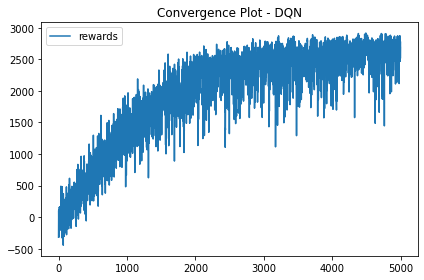

In [ ]:
plt.plot( rewards, label="rewards")
plt.legend()
plt.title("Convergence Plot - DQN")
plt.tight_layout()
plt.show()


In [ ]:
def convergence_graph_q_val(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()



Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)



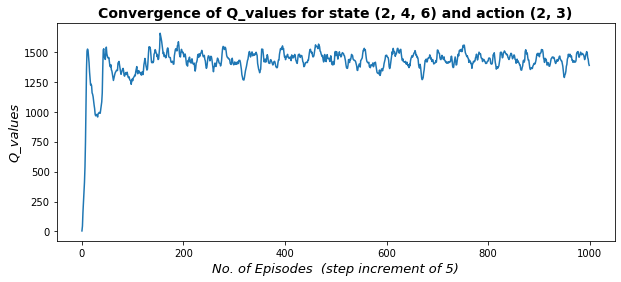

In [ ]:
print('\n\033[1m'+"Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)\n")
convergence_graph_q_val(fig_num=1, state=(2,4,6), action=(2,3), states_tracked= states_tracked_1)





Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)



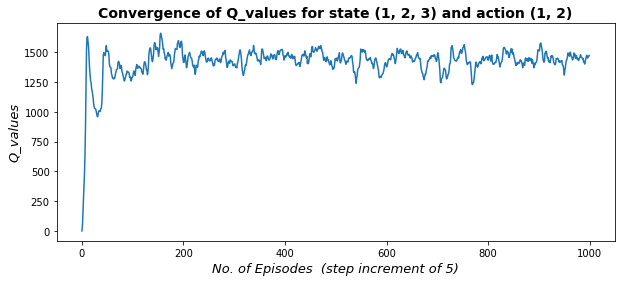

In [ ]:
print('\n\n\n\033[1m'+"Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)\n")
convergence_graph_q_val(fig_num=3, state=(1,2,3), action=(1,2), states_tracked= states_tracked_2)


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

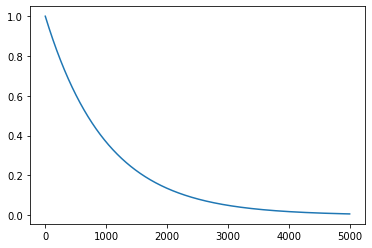

In [ ]:
time = np.arange(0,Episodes)
epsilon = []
for i in range(0,Episodes):
    epsilon.append(0 + (1 - 0) * np.exp(-agent.decay_rate*i))
  
plt.plot(time, epsilon)
plt.show()